In [1]:
#use the corv_wd_models.yml environment

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy import stats
from IPython.display import Image

from astropy.table import Table, Column, MaskedColumn, join, vstack
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
import astropy.units as u
from astropy.coordinates import LSR

import pandas as pd
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#put the path the WD_models and import the module
import sys
import os
sys.path.append('../Software')
import WD_models

plt.style.use('stefan.mplstyle')

# This notebook calculates masses for each WD and LSR corrections to the RV. Then we perform data quality cuts to get the final sample for the EoS plots and correct the RVs for the asymmetric drift of this sample and bin the sample in radius/surface gravity. We then save the final full samples and the final temperature dependence samples.

# Import the datasets


In [2]:
SDSSV_tab=pd.read_csv('csv/SDSSV_DA_df.csv')
eSDSS_tab=pd.read_csv('csv/eSDSS_DA_df.csv')

# Import the La Plata WD Models
- http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html
- Varying H-layer thickness according to mass of WD, more massive WDs have thicker H layers than less massive
- DAmassradiusZ0.02.txt gives DA mass/radius in solar units as function of logg/log teff
    - He-core: Althaus et al. 2013, CO-core: Camisassa et al. 2016,    ONe-core: Camisassa et al. 2019

In [3]:
la_plata_mass=pd.read_csv('data/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_mass=la_plata_mass.rename(columns={"Unnamed: 1": "logteff"})
la_plata_mass=la_plata_mass.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_mass))
la_plata_mass.set_index(indices,inplace=True)

la_plata_radius=pd.read_csv('data/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_radius=la_plata_radius.rename(columns={"Unnamed: 1": "logteff"})
la_plata_radius=la_plata_radius.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_radius))
la_plata_radius.set_index(indices,inplace=True)

#separate mass and radius info
for col in la_plata_mass.columns.to_list()[1:]:
    masses=[]
    radii=[]
    for i in range(len(la_plata_mass)):
        mass,radius=la_plata_mass[col][i].split(',')
        masses.append(float(mass))
        radii.append(float(radius))
    la_plata_mass[col]=masses
    la_plata_radius[col]=radii

In [4]:
#turn models into interpolation grids

#make grid of mass/radius as function of teff/logg
rows=la_plata_mass['logteff']
teffs = 10**(rows)
columns=la_plata_radius.columns.to_list()[1:]
loggs=[float(i) for i in columns]
mass_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
radius_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        mass_teff_logg_grid[i,j] = la_plata_mass.query('logteff==@logteff')[columns[j]]
        radius_teff_logg_grid[i,j] = la_plata_radius.query('logteff==@logteff')[columns[j]]
    
#get equal-sized arrays
teffs_long=[]
loggs_long=[]
masses_long=[]
radii_long=[]
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        teff=teffs[i]
        logg=loggs[j]
        mass= la_plata_mass.query('logteff==@logteff')[columns[j]].to_list()[0]
        radius= la_plata_radius.query('logteff==@logteff')[columns[j]].to_list()[0]
        teffs_long.append(teff)
        loggs_long.append(logg)
        masses_long.append(mass)
        radii_long.append(radius)   
teffs_long=np.asarray(teffs_long)
loggs_long=np.asarray(loggs_long)
masses_long=np.asarray(masses_long)
radii_long=np.asarray(radii_long)

#define the interpolation functions
mass_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=masses_long, interp_type='linear')     
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
radius_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=radii_long, interp_type='linear')  
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  


# Add the masses to the data frame

- mass_rad_logg is obtained by combining the measured photometric radius with the measured spectroscopic logg

$$M(R,\log{g})=gR^2/G=10^{\log{g}}R^2/G$$
$$\delta M(R,\log{g})=\frac{10^{\log{g}}R}{G}\sqrt{4\delta R^2+(R\ln{10})^2\delta(\log{g})^2}$$

- mass_logg_theory is obtained by combining the measured spectroscopic logg and spectroscopic effective temperature with the La Plata models
    - The error on this quantity is taken from calculating the masses at the endpoints of the logg and teff errorbars and taking the largest difference in masses
- mass_radius_theory is obtained by combining the measured photometric radius and photometric effective temperature with the La Plata models
    - The error on this quantity is taken from calculating the masses at the endpoints of the logg and teff errorbars and taking the largest difference in masses

In [5]:
MsunCGS=1.989*10**33 #g
RsunCGS=6.955*10**10 #cm
cCGS=2.99792458*10**10 #cm/s
GCGS=6.6743*10**(-8) #cm^3 g^-1 s^-2

def data_m_from_r_logg(radii,loggs,e_radii,e_loggs):
    #compute the mass and error on the mass in solar units
    #given measured radius and logg
    masses=[]
    e_masses=[]
    #convert radii from solar units to CGS units
    radii=radii*RsunCGS
    e_radii=e_radii*RsunCGS
    #get the surface gravity
    gs=10**(loggs)
    for i in range(len(radii)):
        M=(gs[i]*(radii[i]**2)/GCGS)/MsunCGS
        masses.append(M)
        E_M=((gs[i]*radii[i]/GCGS)*np.sqrt(4*(e_radii[i]**2)+((radii[i]*np.log(10))**2)*(e_loggs[i]**2)))/MsunCGS
        e_masses.append(E_M)
    return(masses,e_masses)

def data_m_from_logg_theory(loggs,teffs,e_loggs,e_teffs):
    #compute the mass and error on the mass in solar units
    #given measured logg and teff
    masses=[]
    e_masses=[]
    for i in range(len(loggs)):
        #get the logg/teff and their mins and maxes
        logg=loggs[i]
        e_logg=e_loggs[i]
        teff=teffs[i]
        e_teff=e_teffs[i]
        logg_min=logg-e_logg
        logg_max=logg+e_logg
        teff=teffs[i]
        teff_min=teff-e_teff
        teff_max=teff+e_teff
        #calculate the mass and all possible masses
        M=mass_from_logg_teff(logg,teff)
        E_M_array=mass_from_logg_teff([logg_min,logg_min,logg_max,logg_max],[teff_min,teff_max,teff_min,teff_max])
        E_M=max(E_M_array)-min(E_M_array)
        masses.append(M.item())
        e_masses.append(E_M.item())
    return(masses,e_masses)

def data_m_from_rad_theory(radii,teffs,e_radii,e_teffs):
    #compute the mass and error on the mass in solar units
    #given measured radius and teff
    masses=[]
    e_masses=[]
    for i in range(len(radii)):
        #get the logg/teff and their mins and maxes
        rad=radii[i]
        e_rad=e_radii[i]
        teff=teffs[i]
        e_teff=e_teffs[i]
        rad_min=rad-e_rad
        rad_max=rad+e_rad
        teff=teffs[i]
        teff_min=teff-e_teff
        teff_max=teff+e_teff
        #calculate the mass and all possible masses
        M=mass_from_radius_teff(rad,teff)
        E_M_array=mass_from_radius_teff([rad_min,rad_min,rad_max,rad_max],[teff_min,teff_max,teff_min,teff_max])
        E_M=max(E_M_array)-min(E_M_array)
        masses.append(M.item())
        e_masses.append(E_M.item())
    return(masses,e_masses)


In [6]:
def add_masses(table):
    #compute the mass in solar units using coadded spectral parameters
    
    #from measured logg and measured radius
    mass_rad_logg, e_mass_rad_logg=data_m_from_r_logg(table['radius_phot'],table['logg_prf_coadd'],table['e_radius_phot_full'],
                                table['e_logg_prf_coadd_full'])
    
    #from measured logg/teff and theory
    mass_logg_theory, e_mass_logg_theory=data_m_from_logg_theory(table['logg_prf_coadd'],table['teff_prf_coadd'],table['e_logg_prf_coadd_full'],
                                table['e_teff_prf_coadd_full'])
    
    #from measured radius/teff and theory
    mass_rad_theory, e_mass_rad_theory=data_m_from_rad_theory(table['radius_phot'],table['teff_phot'],table['e_radius_phot_full'],
                                table['e_teff_phot_full'])
    
    table['mass_rad_logg']=mass_rad_logg
    table['e_mass_rad_logg']=e_mass_rad_logg
    
    table['mass_logg_theory']=mass_logg_theory
    table['e_mass_logg_theory']=e_mass_logg_theory
    
    table['mass_rad_theory']=mass_rad_theory
    table['e_mass_rad_theory']=e_mass_rad_theory

    
    return(table)

In [7]:
SDSSV_tab=add_masses(SDSSV_tab)
eSDSS_tab=add_masses(eSDSS_tab)

### Compare our masses to the Kepler DR14 mass distribution

In [8]:
def read_DR14(filename,table):
    #read in the DR14 table data
    DR14_df = pd.read_csv('data/'+filename,delimiter='|')
    #drop the last row of NaNs and the first row of dashes
    DR14_df=DR14_df.dropna()
    DR14_df=DR14_df.drop([0])
    #reset the indices
    indices=np.arange(0,len(DR14_df))
    DR14_df.set_index(indices,inplace=True)
    #remove space from column names and type column
    DR14_df.columns = DR14_df.columns.str.replace(' ', '')
    DR14_df['Type']=DR14_df['Type'].str.replace(' ', '')
    #rename columns
    DR14_df=DR14_df.rename(columns={"Type":"Type_DR14"})
    #separate into plate, mjd, and fiber columns
    plates=[]
    mjds=[]
    fibers=[]
    for pmf in DR14_df['P-M-F'].to_list():
        plate,mjd,fiber=pmf.split('-')
        plates.append(plate)
        mjds.append(mjd)
        fibers.append(fiber)
    DR14_df['Plate']=plates
    DR14_df['MJD']=mjds
    DR14_df['Fiber']=fibers
    #standardize PMFs to compare across data releases
    cols=['Plate','MJD','Fiber']
    for col in cols:
        DR14_df[col]=DR14_df[col].astype(int) #convert first to integer to strip 0s
        DR14_df[col]=DR14_df[col].astype(str) #convert back to string
    #add unique PMF identifyer
    DR14_df['PMF']=DR14_df['Plate']+DR14_df['MJD']+DR14_df['Fiber']
    #make dataframe of all WDs in this data set their type and their PMF
    output=DR14_df[['Plate','MJD','Fiber','PMF','Type_DR14']]
    #add flag to signify which DRs each object is in
    flag=np.full(len(output),True)
    output['DR14_flag']=flag 
    #add flag to signify which table each object is in
    flag=np.full(len(output),table)
    output['DR14_table']=flag 
    return(output,DR14_df)

In [9]:
#read in the DR14 table3 data
DR14_table3,DR14_table3_full=read_DR14('keplerDR14_table3.dat.gz.txt','table3')

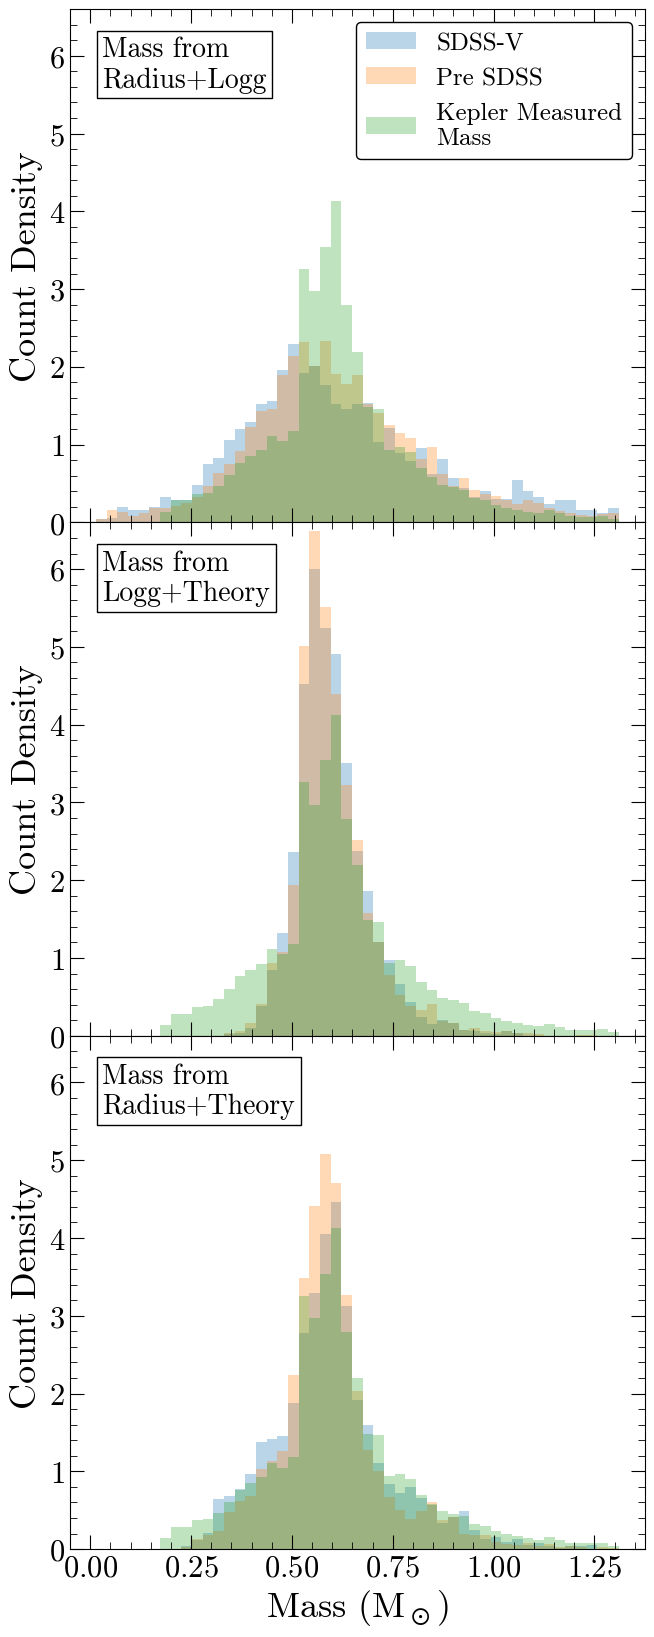

In [10]:
#make quality cut of coadd spectrum SNR>20
#we use only coadds so drop duplicate gaia dr3 source ids

snr_cut=20

SDSSV_tab_cut=SDSSV_tab.drop_duplicates(subset='gaia_dr3_source_id').query('snr_coadd>@snr_cut')
eSDSS_tab_cut=eSDSS_tab.drop_duplicates(subset='gaia_dr3_source_id').query('snr_coadd>@snr_cut')

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3, 1,figsize=(10,20),sharey=True,sharex=True)
#set bin size
bins=np.linspace(0.014,1.310,50)

#plot the Kepler measured masses vs our eSDSS and SDSS-V distributions
ax1.hist(SDSSV_tab_cut['mass_rad_logg'],bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='SDSS-V')
ax1.hist(eSDSS_tab_cut['mass_rad_logg'],bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='Pre SDSS')
ax1.hist(DR14_table3_full['Mass'].astype('float').to_list(), bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='Kepler Measured\nMass')
ax1.text(0.03, 5.6, 'Mass from\nRadius+Logg', fontsize = 20, bbox = dict(facecolor = 'white'))
ax1.set_ylabel('Count Density')
ax1.set_ylim(0,6.6)

#plot the Kepler measured masses vs our eSDSS and SDSS-V logg distributions
#converted to mass distributions
ax2.hist(SDSSV_tab_cut['mass_logg_theory'],bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='SDSS-V')
ax2.hist(eSDSS_tab_cut['mass_logg_theory'],bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='Pre SDSS')
ax2.hist(DR14_table3_full['Mass'].astype('float').to_list(), bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='Kepler Measured\nMass')
ax2.text(0.03, 5.6, 'Mass from\nLogg+Theory', fontsize = 20, bbox = dict(facecolor = 'white'))
ax2.set_ylabel('Count Density')

#plot the Kepler measured masses vs our eSDSS and SDSS-V radius distributions
#converted to mass distributions
ax3.hist(SDSSV_tab_cut['mass_rad_theory'],bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='SDSS-V')
ax3.hist(eSDSS_tab_cut['mass_rad_theory'],bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='Pre SDSS')
ax3.hist(DR14_table3_full['Mass'].astype('float').to_list(), bins=bins,density=True,histtype='stepfilled',alpha=0.3,label='Kepler Measured\nMass')
ax3.text(0.03, 5.6, 'Mass from\nRadius+Theory', fontsize = 20, bbox = dict(facecolor = 'white'))
ax3.set_xlabel('Mass ($M_\odot$)')
ax3.set_ylabel('Count Density')

ax1.legend()#fontsize=22,loc='upper right')#,bbox_to_anchor=(2.0, 0.8))
 
plt.subplots_adjust(wspace=0, hspace=0,right=0.7)

plt.savefig('mass_distribution.pdf')#,pad_inches=0.3)

# Correct the RVs to the local standard of rest (LSR)
- SDSS spectra are wavelength-calibrated in the solar system barycenter. We assume our sample is a locally co-moving population since all stars lie within 500 parsecs of the Sun (Binney & Tremaine 1987). Under this assumption, we correct our apparent radial velocity measurements to the local standard of rest (LSR). We assume the solar velocity relative to the local standard of rest to be $$(U, V, W )= (11.1, 12.24, 7.25) \text{ km s}^{−1}$$ (Sch ̈onrich et al. 2010). We use the coordinate transform tool from astropy to perform a 3-D velocity transform using our measured radial velocities along with geometric distances from Gaia (Bailer-Jones et al. 2018) and calculate LSRcorrected radial velocities for our sample.
- After this correction, the observed apparent radial velocity is solely due to the gravitational redshift plus the Doppler shift of random stellar motions caused by noncircular orbits in the galaxy (Falcon et al. 2010).
- https://docs.astropy.org/en/stable/coordinates/velocities.html
- https://docs.astropy.org/en/stable/api/astropy.coordinates.LSR.html#astropy.coordinates.LSR

In [11]:
def lsr_corr(table):
    #make a SkyCoord object with the WD spatial and velocity coordinates
    sc = SkyCoord(ra=table['ra'].to_list()*u.deg, 
                  dec=table['dec'].to_list()*u.deg, 
                  distance=table['r_med_geo'].to_list()*u.pc,
                  pm_ra_cosdec=table['pmra'].to_list()*u.mas/u.yr,
                  pm_dec=table['pmdec'].to_list()*u.mas/u.yr,
                  radial_velocity=table['rv_corv_coadd'].to_list()*u.km/u.s)
    
    #convert to LSR
    sc_lsr=sc.lsr
    
    #add to the dataframe
    table['rv_corv_lsr']=sc_lsr.radial_velocity.value
    
    #the uncertainty in this is just E_RV_corv_full since all other parameters have negligible uncertainties
    
    return(table)

In [12]:
SDSSV_tab=lsr_corr(SDSSV_tab)
eSDSS_tab=lsr_corr(eSDSS_tab)

In [13]:
#what is the typical LSR correction

SDSSV_lsr_corr=SDSSV_tab.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_coadd']-SDSSV_tab.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_lsr']
eSDSS_lsr_corr=eSDSS_tab.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_coadd']-eSDSS_tab.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_lsr']

print('min and max corr for SDSSV=',min(SDSSV_lsr_corr),', ',max(SDSSV_lsr_corr))
print('min and max corr for eSDSS=',min(eSDSS_lsr_corr),', ',max(eSDSS_lsr_corr))
print('')

print('overall mean corr for SDSSV=',np.mean(SDSSV_lsr_corr),'for eSDSS=',np.mean(eSDSS_lsr_corr))
print('overall mean abs corr for SDSSV=',np.mean(np.abs(SDSSV_lsr_corr)),'for eSDSS=',np.mean(np.abs(eSDSS_lsr_corr)))
print('')

SDSSV_mean_l=np.mean(SDSSV_tab['l'])
SDSSV_mean_b=np.mean(SDSSV_tab['b'])
eSDSS_mean_l=np.mean(eSDSS_tab['l'])
eSDSS_mean_b=np.mean(eSDSS_tab['b'])

print('SDSSV mean l,b=',SDSSV_mean_l,SDSSV_mean_b)
print('eSDSS mean l,b=',eSDSS_mean_l,eSDSS_mean_b)
print('')

SDSSV_peak_coord=SDSSV_tab.query('@SDSSV_mean_l-10<l<@SDSSV_mean_l+10 & @SDSSV_mean_b-10<b<@SDSSV_mean_b+10')
eSDSS_peak_coord=eSDSS_tab.query('@eSDSS_mean_l-10<l<@eSDSS_mean_l+10 & @eSDSS_mean_b-10<b<@eSDSS_mean_b+10')
SDSSV_lsr_corr=SDSSV_peak_coord['rv_corv_coadd']-SDSSV_peak_coord['rv_corv_lsr']
eSDSS_lsr_corr=eSDSS_peak_coord['rv_corv_coadd']-eSDSS_peak_coord['rv_corv_lsr']
print('at mean (l,b), mean corr for SDSSV=',np.mean(SDSSV_lsr_corr),'for eSDSS=',np.mean(eSDSS_lsr_corr))
print('at mean (l,b), mean abs corr for SDSSV=',np.mean(np.abs(SDSSV_lsr_corr)),'for eSDSS=',np.mean(np.abs(eSDSS_lsr_corr)))
print('')

#eSDSS has far more WDs at b=+-50 and none at b=0, SDSSV has more at b=0

SDSSV_peak_coord=SDSSV_tab.query('@SDSSV_mean_l-10<l<@SDSSV_mean_l+10 & -10<b<10')
eSDSS_peak_coord=eSDSS_tab.query('@eSDSS_mean_l-10<l<@eSDSS_mean_l+10 & 40<b<60')
SDSSV_lsr_corr=SDSSV_peak_coord['rv_corv_coadd']-SDSSV_peak_coord['rv_corv_lsr']
eSDSS_lsr_corr=eSDSS_peak_coord['rv_corv_coadd']-eSDSS_peak_coord['rv_corv_lsr']
print('at mean l, mean corr for SDSSV (b=0)=',np.mean(SDSSV_lsr_corr),'for eSDSS (b=50)=',np.mean(eSDSS_lsr_corr))
print('at mean l, mean abs corr for SDSSV(b=0)=',np.mean(np.abs(SDSSV_lsr_corr)),'for eSDSS (b=50)=',np.mean(np.abs(eSDSS_lsr_corr)))
print('')

min and max corr for SDSSV= -17.87742397031387 ,  17.154092693068424
min and max corr for eSDSS= -18.037630346250538 ,  16.779690616743242

overall mean corr for SDSSV= -6.295560123715349 for eSDSS= -3.092690273327721
overall mean abs corr for SDSSV= 11.626223251095627 for eSDSS= 8.203494402343855

SDSSV mean l,b= 135.36503917372283 12.667741450621715
eSDSS mean l,b= 149.10255883123094 31.10749527926013

at mean (l,b), mean corr for SDSSV= -1.0122706319763146 for eSDSS= -0.7394892570748067
at mean (l,b), mean abs corr for SDSSV= 1.0921232780523247 for eSDSS= 0.8037880148904509

at mean l, mean corr for SDSSV (b=0)= -0.6439956810604786 for eSDSS (b=50)= -3.214974866106202
at mean l, mean abs corr for SDSSV(b=0)= 0.6827475761564058 for eSDSS (b=50)= 3.214974866106202



# Create tables for temperature-dependence paper measurements
- We use only coadded parameters so drop all gaia_dr3_source_id duplicates and information about individual spectra

In [14]:
#keep only the relevant columns
SDSSV_tab_tempdep=SDSSV_tab[['gaia_dr3_source_id','ra', 'dec','l','b','r_med_geo','phot_g_mean_mag','pmra','pmdec',
                             'rv_corv_coadd','e_rv_corv_coadd_full','snr_coadd','nspec_coadd','teff_prf_coadd',
                             'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','phot_used','phot_err_sdss',
                             'phot_err_gaia','radius_phot','e_radius_phot_full','teff_phot','e_teff_phot_full',
                             'mass_rad_logg','e_mass_rad_logg','mass_logg_theory','e_mass_logg_theory',
                             'mass_rad_theory','e_mass_rad_theory','rv_corv_lsr']].drop_duplicates(subset='gaia_dr3_source_id')
#reset the indices
indices=np.arange(0,len(SDSSV_tab_tempdep))
SDSSV_tab_tempdep.set_index(indices,inplace=True)

eSDSS_tab_tempdep=eSDSS_tab[['gaia_dr3_source_id','ra', 'dec','l','b','r_med_geo','phot_g_mean_mag','pmra','pmdec',
                             'rv_corv_coadd','e_rv_corv_coadd_full','snr_coadd','nspec_coadd','teff_prf_coadd',
                             'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','phot_used','phot_err_sdss',
                             'phot_err_gaia','radius_phot','e_radius_phot_full','teff_phot','e_teff_phot_full',
                             'mass_rad_logg','e_mass_rad_logg','mass_logg_theory','e_mass_logg_theory',
                             'mass_rad_theory','e_mass_rad_theory','rv_corv_lsr']].drop_duplicates(subset='gaia_dr3_source_id')
#reset the indices
indices=np.arange(0,len(eSDSS_tab_tempdep))
eSDSS_tab_tempdep.set_index(indices,inplace=True)
    

# Perform quality cuts

We only want objects with good spectra and photometry.

- SDSS coadd spectra SNR>10
    - For some of these objects, there may not be a corresponding weighted mean RV if no individual spectrum has a snr>10. This is why we prefer to use the coadded spectrum parameters
- Tremblay models are used to fit RVs and to fit phot teff/radius but these models only cover 1500<Teff<130,000K so remove any objects on the edge of the grid
    - Also restrict spectroscopic loggs/teffs to this range. The PRF routine can return measurements outside of this range but there is very very sparse training data in those regimes so those measurements should be considered unreliable and be excluded from this analysis
    - Take 1600<teff_phot<129,000 K and 1600<teff_prf_coadd<129,000 K
    - Take 7<logg_prf_coadd<9 dex
- Bailer-Jones distance r_med_geo<500 pc
    - Need objects within 500 pc in order for the WDs to be locally comoving (see below) and to have more reliable distance measurements
- e_rv_corv_coadd_full<50 km/s, make sure RV fit is decent
- Restrict the full error on the measured radius and logg to be <3 times the bin width
    - E_Radius_Phot_full<$0.002*3$ Rsun, make sure radius fit is decent
    - E_Logg_prf_coadd_full<$0.1*3$ dex, make sure logg fit is decent

### Show quality cuts

In [15]:
def data_cut(table,binmult,figtitle):
    #plot the data quality cuts
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) =plt.subplots(4,2,figsize=(12,25))
    
    ax1.hist(table['snr_coadd'],histtype='step')
    ax1.axvline(x = 10, color = 'r')
    ax1.set_xlabel(r'SDSS Coadd Spectrum SNR')
    ax1.set_ylabel(r'Counts')

    ax2.hist(table['logg_prf_coadd'],histtype='step')
    ax2.axvline(x = 7, color = 'r')
    ax2.axvline(x = 9, color = 'r')
    ax2.set_xlabel(r'Spectroscopic Logg (dex)')
    
    ax3.hist(table['teff_phot'],histtype='step')
    ax3.axvline(x = 1600, color = 'r')
    ax3.axvline(x = 129000, color = 'r')
    ax3.set_xlabel(r'Photometric Teff (K)')
    ax3.set_ylabel(r'Counts')
    
    ax4.hist(table['teff_prf_coadd'],histtype='step')
    ax4.axvline(x = 1600, color = 'r')
    ax4.axvline(x = 129000, color = 'r')
    ax4.set_xlabel(r'Spectroscopic Teff (K)')
    
    ax5.hist(table['r_med_geo'],histtype='step')
    ax5.axvline(x = 500, color = 'r')
    ax5.set_xlabel(r'Bailer-Jones Distance (pc)')
    ax5.set_ylabel(r'Counts')
    ax5.set_xlim(0,2000)
    
    ax6.hist(table['e_rv_corv_coadd_full'],histtype='step')
    ax6.axvline(x = 50, color = 'r')
    ax6.set_xlabel(r'Full corv RV Error (km/s)')
    ax6.set_xlim(0,200)
    
    """
    ax7.hist(table['e_radius_phot_full'],histtype='step')
    ax7.axvline(x = 0.002*binmult, color = 'r')
    ax7.set_xlabel(r'Full Radius Error (Rsun)')
    ax7.set_ylabel(r'Counts')
    ax7.set_xlim(0,0.02)
    """
    
    ax8.hist(table['e_logg_prf_coadd_full'],histtype='step')
    ax8.axvline(x = 0.1*binmult, color = 'r')
    ax8.set_xlabel(r'Full Logg Error (dex)')
    #ax8.set_xlim(0,1)
    
    fig.suptitle(figtitle,y=0.9)
    

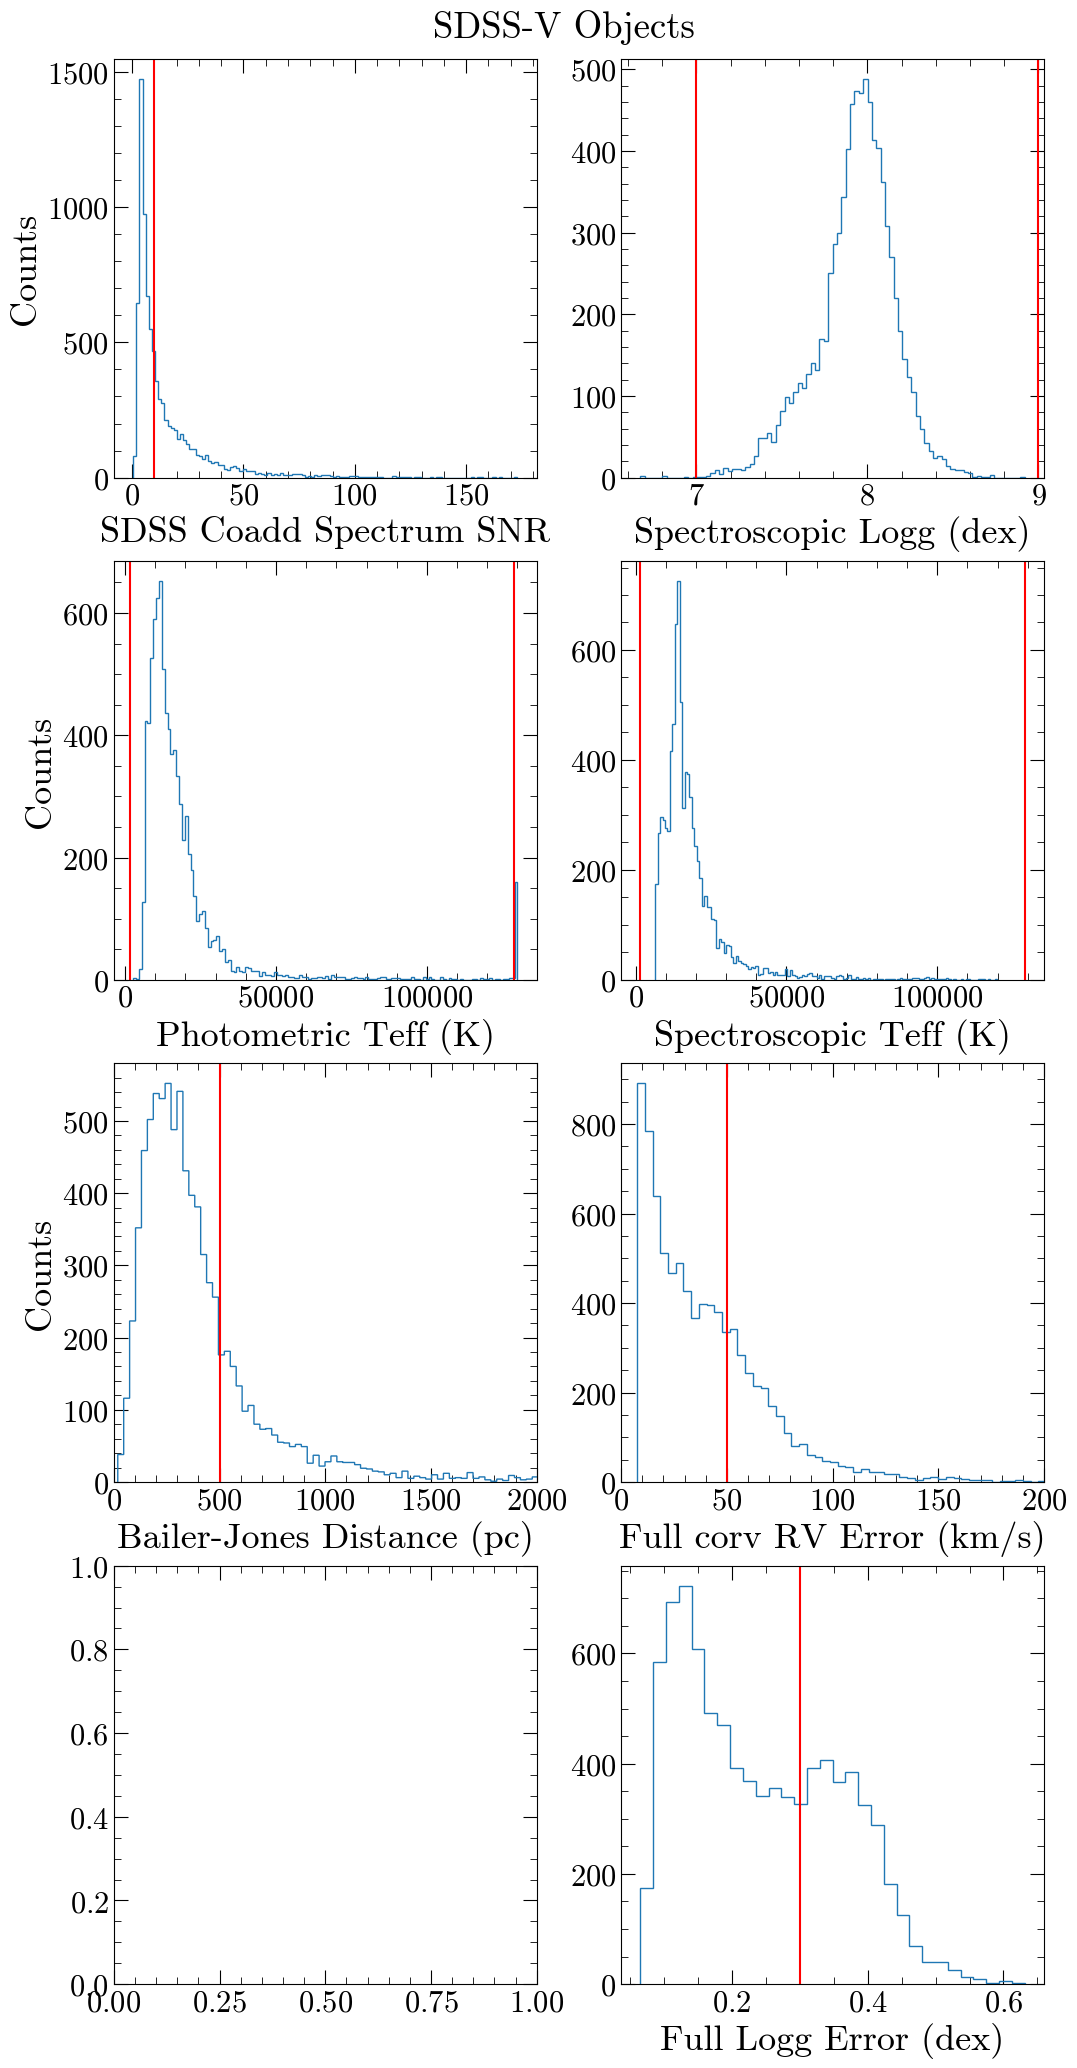

In [16]:
data_cut(SDSSV_tab_tempdep,3,'SDSS-V Objects')

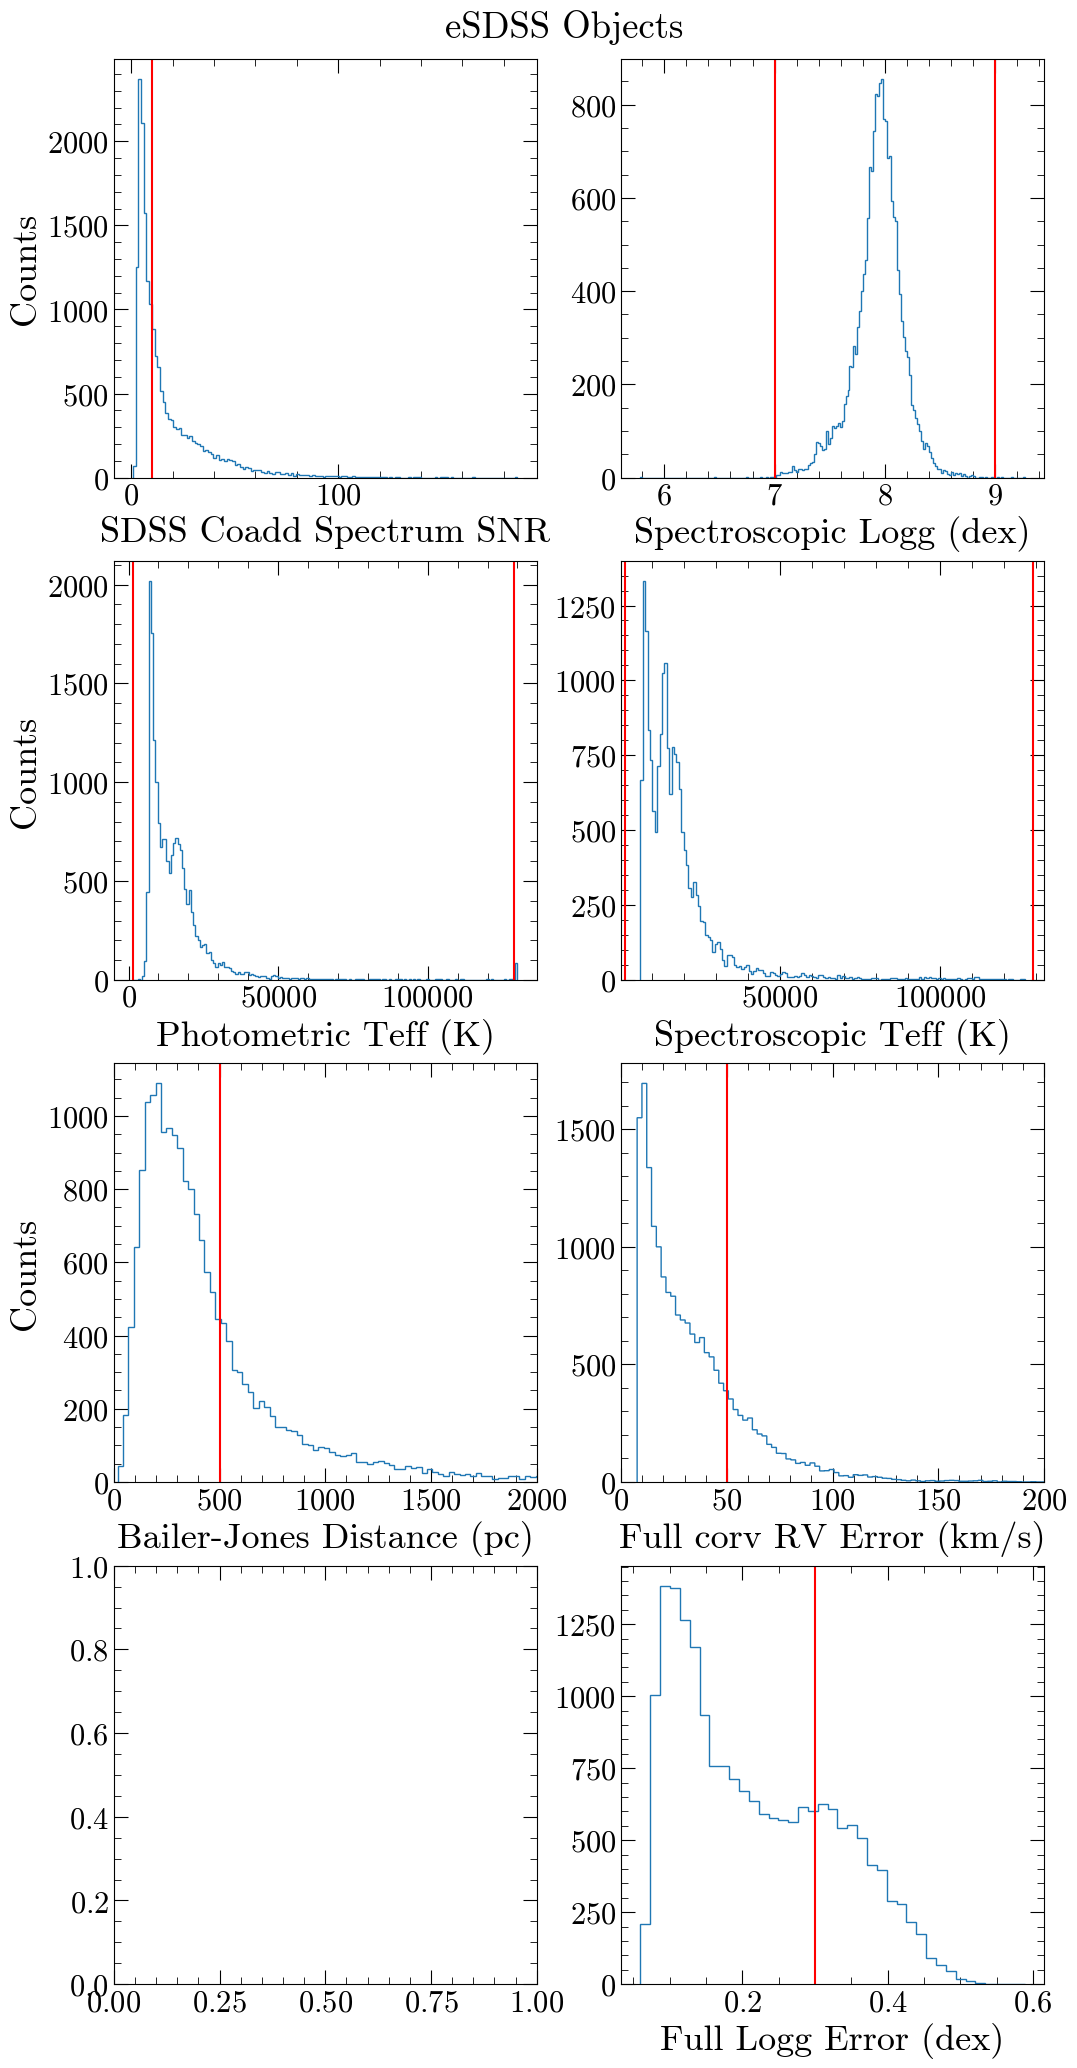

In [17]:
data_cut(eSDSS_tab_tempdep,3,'eSDSS Objects')

### Do quality cuts
- The most stringent cut is the SNR cut

In [18]:
print('total number independent objects=',len(SDSSV_tab_tempdep))
print('')

binmult=3
print('binmult=3')

#show effect of snr cut
SDSSV_tab_tempdep=SDSSV_tab_tempdep.query('snr_coadd>10')
print('cut on snr_coadd')
print('number independent objects=',len(SDSSV_tab_tempdep))

SDSSV_tab_tempdep=SDSSV_tab_tempdep.query('7<logg_prf_coadd<9 and 1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and r_med_geo<500 and e_rv_corv_coadd_full<50 and e_radius_phot_full<0.002*@binmult and e_logg_prf_coadd_full<0.1*@binmult')
print('cut on logg, teff, distance, RV error, radius error, and logg error')
print('number independent objects=',len(SDSSV_tab_tempdep))



total number independent objects= 8545

binmult=3
cut on snr_coadd
number independent objects= 3772
cut on logg, teff, distance, RV error, radius error, and logg error
number independent objects= 2934


In [19]:
print('total number independent objects=',len(eSDSS_tab_tempdep))
print('')

binmult=3
print('binmult=3')

#show effect of snr cut
eSDSS_tab_tempdep=eSDSS_tab_tempdep.query('snr_coadd>10')
print('cut on snr_coadd')
print('number independent objects=',len(eSDSS_tab_tempdep))

eSDSS_tab_tempdep=eSDSS_tab_tempdep.query('7<logg_prf_coadd<9 and 1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and r_med_geo<500 and e_rv_corv_coadd_full<50 and e_radius_phot_full<0.002*@binmult and e_logg_prf_coadd_full<0.1*@binmult')
print('cut on logg, teff, distance, RV error, radius error, and logg error')
print('number independent objects=',len(eSDSS_tab_tempdep))


total number independent objects= 19257

binmult=3
cut on snr_coadd
number independent objects= 9677
cut on logg, teff, distance, RV error, radius error, and logg error
number independent objects= 7331


# Remove Halo WDs
- Most of the stars near the sun belong to the disk, so the mean speed of the LSR is dominated by disk stars
- Halo stars have high speeds relative to LSR
    - Thin disk stars don’t typically deviate by more than 80 -120 km/s from LSR (Ninkovic 2012)
    - Halo stars often identified by speed >220 km/s relative to LSR cut (Du 2018)
    - Within 80 km/s of LSR ≤ 5% of stars are Halo stars, within 120 km/s ≤ 10%, among high-velocity stars (over 100km/s) halo stars are almost as common as disk stars (Ninkovic 2012)
- Local density of halo WDs is 10^-5 - 10^-4 per pc^3 (Isern 1998)
    - 0.24 to 0.46 white dwarfs in a sphere of 10 pc of radius around the Sun
    - ~5000-50,000 within 500 pc radius around Sun (lots!)

Cut
- Calculate mean LSR-corrected RV of entire sample, this is total mean gravitational redshift
- Subtract the total mean gravitational redshift to get ~just the RV for each object in sample (otherwise distribution is skewed)
- Test cuts of |corv_RV_LSR-mean grav redshift|< 120 or 220 km/s to remove halo WDs
- We choose to go with the more conservative 120 km/s cut. The 220 km/s cut only removes <~5 objects from each table


In [20]:
def halo_cut(table,threshold,plot=False):
    #calculate mean grav redshift for whole sample
    mean_vg=np.mean(table['rv_corv_lsr'])
    print('mean grav redshift=',mean_vg)
    #subtract this mean grav redshift
    table['rv_corv_lsr_vg']=table['rv_corv_lsr']-mean_vg
    
    if plot==True:
        #show cut
        fig, (ax1) =plt.subplots(1,1,figsize=(6,6))
        ax1.hist(table['rv_corv_lsr_vg'],histtype='step')
        ax1.axvspan(-120,120, color = 'g',alpha=0.5,label='Within 120 km/s')
        ax1.axvspan(-220,220, color = 'y',alpha=0.3,label='Within 220 km/s')
        ax1.set_xlabel(r'LSR RV-Mean $v_g$')
        ax1.set_ylabel(r'Counts')
        ax1.set_xlim(-300,300)
        
    #cut out halo WDs
    if plot==True:
        print('threshold='+str(threshold)+' km/s')
        print('number independent objects=',len(table))
        print('')
    table=table.query('-@threshold<rv_corv_lsr_vg<@threshold')
    #reset the indices
    indices=np.arange(0,len(table))
    table.set_index(indices,inplace=True)
    #drop the RV_corv_LSR_vg column which will not be used again
    table=table.drop(columns='rv_corv_lsr_vg')
    if plot==True:
        print('number independent objects=',len(table))
        print('')
    
    return(table)

mean grav redshift= 26.972653217630587
threshold=120 km/s
number independent objects= 7331

number independent objects= 7242

mean grav redshift= 26.972653217630587
threshold=220 km/s
number independent objects= 7331

number independent objects= 7319



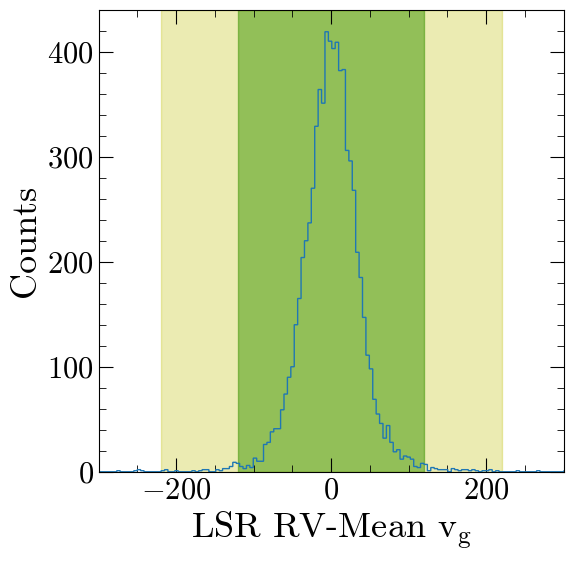

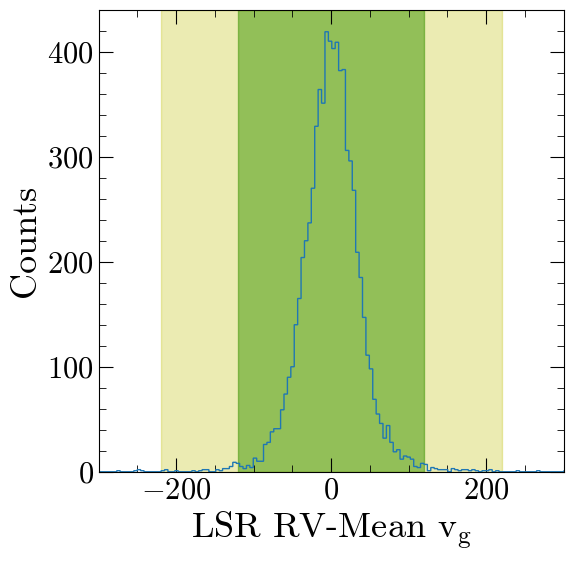

In [21]:
out=halo_cut(eSDSS_tab_tempdep,120,plot=True)
out=halo_cut(eSDSS_tab_tempdep,220,plot=True)

### Implement a quality cut of -120<rv_corv_lsr_vg<120 to remove halo WDs

In [22]:
print(len(SDSSV_tab_tempdep),len(eSDSS_tab_tempdep))
print('')

print('SDSSV')
SDSSV_tab_tempdep=halo_cut(SDSSV_tab_tempdep,120)
print('eSDSS')
eSDSS_tab_tempdep=halo_cut(eSDSS_tab_tempdep,120)

print('')
print(len(SDSSV_tab_tempdep),len(eSDSS_tab_tempdep))

2934 7331

SDSSV
mean grav redshift= 31.947326231262753
eSDSS
mean grav redshift= 26.972653217630587

2887 7242


### Check if there are any nans in measured rv, teff, logg, or radius after data quality cuts
There are not

In [23]:
print(SDSSV_tab_tempdep.isna().any())
print('')
print(eSDSS_tab_tempdep.isna().any())

gaia_dr3_source_id       False
ra                       False
dec                      False
l                        False
b                        False
r_med_geo                False
phot_g_mean_mag          False
pmra                     False
pmdec                    False
rv_corv_coadd            False
e_rv_corv_coadd_full     False
snr_coadd                False
nspec_coadd              False
teff_prf_coadd           False
e_teff_prf_coadd_full    False
logg_prf_coadd           False
e_logg_prf_coadd_full    False
phot_used                False
phot_err_sdss             True
phot_err_gaia            False
radius_phot              False
e_radius_phot_full       False
teff_phot                False
e_teff_phot_full         False
mass_rad_logg            False
e_mass_rad_logg          False
mass_logg_theory          True
e_mass_logg_theory        True
mass_rad_theory           True
e_mass_rad_theory         True
rv_corv_lsr              False
dtype: bool

gaia_dr3_source_id       F

# FINAL SAMPLE SIZE:
### SDSSV=2887 individual WDs
### eSDSS=7242 individual WDs


# Asymmetric Drift Correction

### It is important that this correction represent the asymmetric drift of the population used  to characterize the temperature dependence of WD structure. For other subsets of this catalog used for different purposes, this correction should be re-calculated.

https://www.aanda.org/articles/aa/full_html/2013/09/aa21559-13/aa21559-13.html
- The asymmetric drift of a stellar population is defined as the difference between the velocity of a hypothetical set of stars possessing perfectly circular orbits and the mean rotation velocity of the population under consideration. The velocity of the former is called the standard of rest.
- If the measurements are made at the solar Galactocentric radius, it is the local standard of rest (LSR). The determination of the LSR corresponds to measuring the peculiar motion (U⊙,V⊙,W⊙) of the Sun, where U⊙ is the velocity of the Sun in the direction of the Galactic centre, V⊙ in the direction of the Galactic rotation, and W⊙ in the vertical direction.
- While measuring U⊙ and W⊙ is relatively straightforward, V⊙ requires a sophisticated asymmetric drift correction for its measurement. The asymmetric drift is the difference of the local circular speed $v_c$ and the mean rotational speed of the stellar population. The asymmetric drift corresponds (traditionally with a minus sign to yield positive values for $V_a$) to the measured mean rotational velocity of the stellar sample corrected by the reflex motion of the Sun.
- The sun is moving in the l=90 direction and that is the direction where the asymmetric drift correction needs to be ADDED, because the starts in this direction are rotating a little too slowly due to the asymmetric drift.
- So, we expect the RVs of stars in the l=90 direction to be less than those in the l=270 direction. This is what we find below.

### Show presence of asymmetric drift

In [24]:
SDSSV_tab_unique=SDSSV_tab.drop_duplicates(subset='gaia_dr3_source_id')
eSDSS_tab_unique=eSDSS_tab.drop_duplicates(subset='gaia_dr3_source_id')

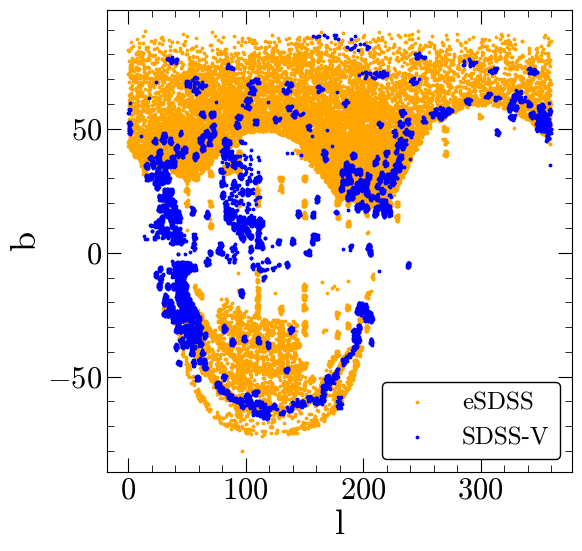

In [25]:
#look at the sky coverage
fig, ax1 =plt.subplots(1,1,figsize=(6,6))
plt.style.use('stefan.mplstyle')
ax1.scatter(eSDSS_tab_unique['l'],eSDSS_tab_unique['b'],s=3,color='orange',label='eSDSS')
ax1.scatter(SDSSV_tab_unique['l'],SDSSV_tab_unique['b'],s=3,color='blue',label='SDSS-V')
ax1.set_xlabel('l')
ax1.set_ylabel('b')
ax1.legend()

Full Sample
345
32
-24.6653641128549

772
174
-10.877048644160377


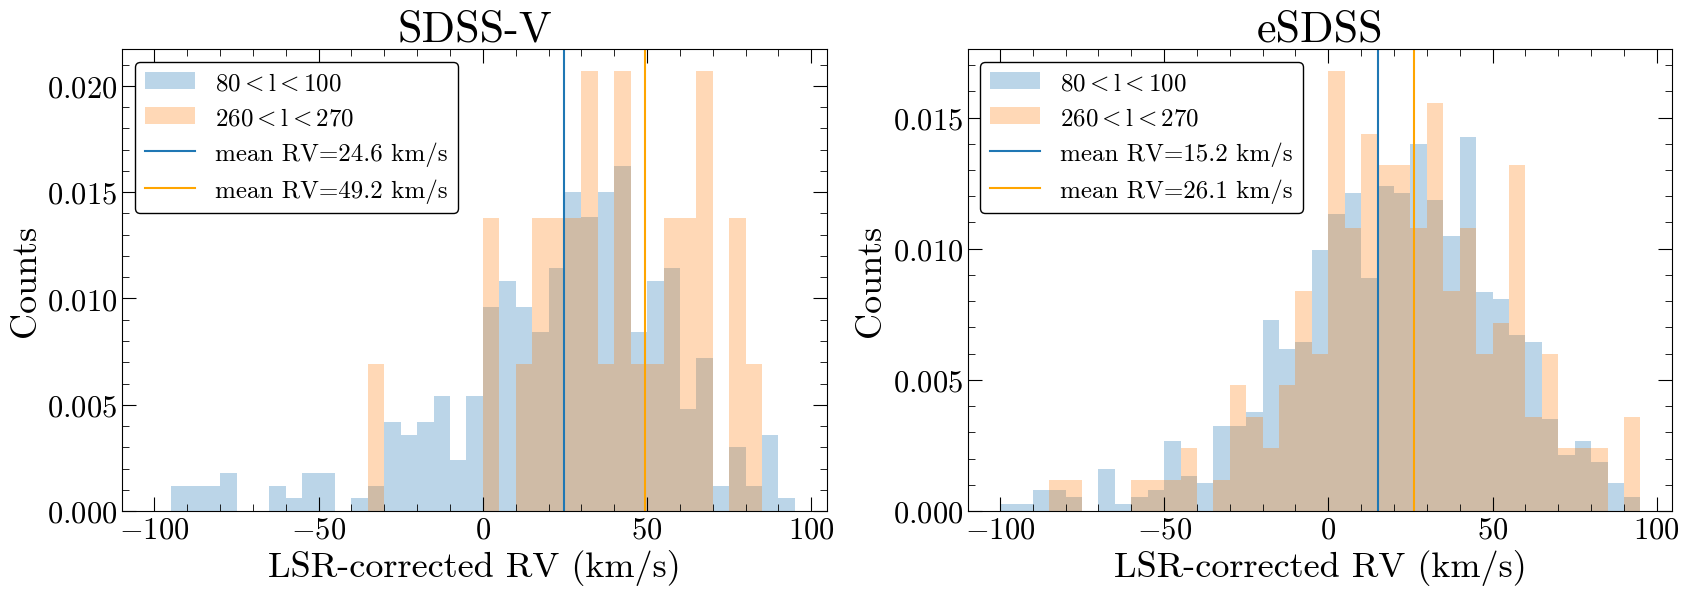

Temperature Dependence Sample
285
24
-14.439626099084649

575
123
-1.3792239741935468


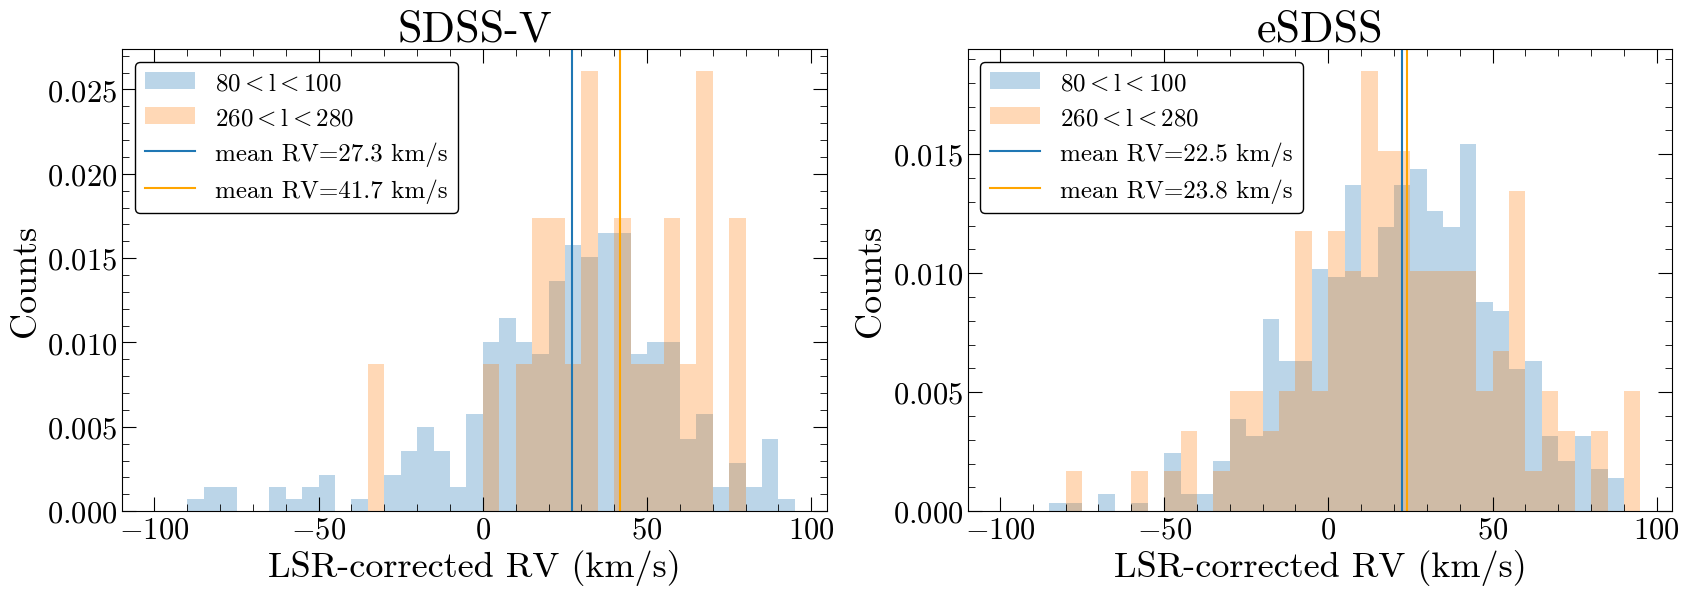

In [26]:
#look at asymmetric drift by plotting LSR-corrected RV distributions
bins=np.arange(-100,100,5)

print('Full Sample')

#make quality cut of snr=10 to get relliable RVs
snr_cut=10
SDSSV_tab_cut=SDSSV_tab_unique.query('snr_coadd>@snr_cut')
eSDSS_tab_cut=eSDSS_tab_unique.query('snr_coadd>@snr_cut')

fig, (ax1,ax2) =plt.subplots(1,2,figsize=(20,6))
l90=SDSSV_tab_cut.query('80<l<100')
l270=SDSSV_tab_cut.query('260<l<280')
print(len(l90))
print(len(l270))
ax1.hist(l90['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{80<l<100}$')
ax1.hist(l270['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{260<l<270}$')
ax1.axvline(x = np.mean(l90['rv_corv_lsr']),label='mean RV='+str(np.round(np.mean(l90['rv_corv_lsr']),1))+' km/s')
ax1.axvline(x = np.mean(l270['rv_corv_lsr']),color='orange',label='mean RV='+str(np.round(np.mean(l270['rv_corv_lsr']),1))+' km/s')
ax1.set_xlabel(r'LSR-corrected RV (km/s)')
ax1.set_ylabel(r'Counts')
ax1.legend()
ax1.set_title('SDSS-V')
print(np.mean(l90['rv_corv_lsr'])-np.mean(l270['rv_corv_lsr']))

print('')

l90=eSDSS_tab_cut.query('80<l<100')
l270=eSDSS_tab_cut.query('260<l<280')
print(len(l90))
print(len(l270))
ax2.hist(l90['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{80<l<100}$')
ax2.hist(l270['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{260<l<270}$')
ax2.axvline(x = np.mean(l90['rv_corv_lsr']),label='mean RV='+str(np.round(np.mean(l90['rv_corv_lsr']),1))+' km/s')
ax2.axvline(x = np.mean(l270['rv_corv_lsr']),color='orange',label='mean RV='+str(np.round(np.mean(l270['rv_corv_lsr']),1))+' km/s')
ax2.set_xlabel(r'LSR-corrected RV (km/s)')
ax2.set_ylabel(r'Counts')
ax2.legend()
ax2.set_title('eSDSS')
print(np.mean(l90['rv_corv_lsr'])-np.mean(l270['rv_corv_lsr']))
plt.show()

print('Temperature Dependence Sample')

#make quality cut of snr=10 to get relliable RVs
snr_cut=10
SDSSV_tab_cut=SDSSV_tab_tempdep.query('snr_coadd>@snr_cut')
eSDSS_tab_cut=eSDSS_tab_tempdep.query('snr_coadd>@snr_cut')

fig, (ax1,ax2) =plt.subplots(1,2,figsize=(20,6))
l90=SDSSV_tab_cut.query('80<l<100')
l270=SDSSV_tab_cut.query('260<l<280')
print(len(l90))
print(len(l270))
ax1.hist(l90['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{80<l<100}$')
ax1.hist(l270['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{260<l<280}$')
ax1.axvline(x = np.mean(l90['rv_corv_lsr']),label='mean RV='+str(np.round(np.mean(l90['rv_corv_lsr']),1))+' km/s')
ax1.axvline(x = np.mean(l270['rv_corv_lsr']),color='orange',label='mean RV='+str(np.round(np.mean(l270['rv_corv_lsr']),1))+' km/s')
ax1.set_xlabel(r'LSR-corrected RV (km/s)')
ax1.set_ylabel(r'Counts')
ax1.legend()
ax1.set_title('SDSS-V')
print(np.mean(l90['rv_corv_lsr'])-np.mean(l270['rv_corv_lsr']))

print('')

l90=eSDSS_tab_cut.query('80<l<100')
l270=eSDSS_tab_cut.query('260<l<280')
print(len(l90))
print(len(l270))
ax2.hist(l90['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{80<l<100}$')
ax2.hist(l270['rv_corv_lsr'],bins=bins,density=True,alpha=0.3,label='$\mathrm{260<l<280}$')
ax2.axvline(x = np.mean(l90['rv_corv_lsr']),label='mean RV='+str(np.round(np.mean(l90['rv_corv_lsr']),1))+' km/s')
ax2.axvline(x = np.mean(l270['rv_corv_lsr']),color='orange',label='mean RV='+str(np.round(np.mean(l270['rv_corv_lsr']),1))+' km/s')
ax2.set_xlabel(r'LSR-corrected RV (km/s)')
ax2.set_ylabel(r'Counts')
ax2.legend()
ax2.set_title('eSDSS')
print(np.mean(l90['rv_corv_lsr'])-np.mean(l270['rv_corv_lsr']))

### Calculate velocity dispersion
Also check that the velocity dispersion as a function of temperature (aka color) and logg/radius (aka mass) is consistent

In [27]:
def dispersion_plot(table,bin_nums,bin_ranges,bin_centers,bin_id_key,RV_key):
    #calculate the mean and std of the RVs for each bin
    mean_RVs=[]
    dispersions=[]
    num_obs_per_bin=[]
    for i in range(len(bin_nums)):
        tmp=table.query(bin_id_key+'=='+str(bin_nums[i]))
        rv=np.array(tmp[RV_key].to_list())
        if len(rv)>0:
            #calculate mean and std of RVs
            mean_RV=np.average(rv)
            std_RV=np.std(rv)
        else: #if bin is empty fill with nan values
            mean_RV=np.nan
            std_RV=np.nan
        #record results
        mean_RVs.append(mean_RV)
        dispersions.append(std_RV)
        #record how many observations used in averaging
        num_obs=len(tmp)
        num_obs_per_bin.append(num_obs)
        
    table=pd.DataFrame()
    table[bin_id_key]=bin_nums
    table['bin_range']=bin_ranges
    table['bin_center']=bin_centers
    table['mean_rvs']=mean_RVs
    table['v_dispersion']=dispersions
    table['num_obs_per_bin']=num_obs_per_bin
    
    #re-order by bin_id
    table=table.sort_values(by=[bin_id_key])
    
    return(table)

In [28]:
def velocity_dispersion(table,verbose=False,plot=False):
    
    #calculate the velocity dispersion of the lsr corrected rvs
    avg_v=np.mean(table['rv_corv_lsr'])
    sigma_v=np.std(table['rv_corv_lsr'])
    if verbose:
        print("mean velocity=",avg_v," km/s")
        print("velocity dispersion=",sigma_v," km/s")
        print('sigma^2=',sigma_v**2)
        
    #drop any nans
    table=table.dropna(subset=['teff_phot','radius_phot','logg_prf_coadd'])
    #reset the indices
    indices=np.arange(0,len(table))
    table.set_index(indices,inplace=True)
        
    if plot==True:
        #check that the velocity dispersion as a function of temperature (aka color) and logg/radius (aka mass)
        #is consistent
        
        #bin by photometric teff
        t_bins=np.round(np.arange(1000,134000,4000),1)
        t_bin_ranges=[]
        t_bin_half_pts=[]
        for i in range(len(t_bins)-1):
            array=[t_bins[i],t_bins[i+1]]
            half=0.5*(t_bins[i]+t_bins[i+1])
            t_bin_ranges.append(array)
            t_bin_half_pts.append(half)
        t_bin_nums=np.arange(0,len(t_bin_ranges))
        t_bin_ids=[]
        t_bin_id_ranges=[]
        t_bin_id_centers=[]
        for i in range(len(table)):
            teff=table['teff_phot'][i]
            for j in range(len(t_bin_ranges)):
                if t_bin_ranges[j][0]<teff<=t_bin_ranges[j][1]:
                    t_bin_ids.append(j)
                    t_bin_id_ranges.append(t_bin_ranges[j])
                    t_bin_id_centers.append(t_bin_half_pts[j])
        table['teff_bin_id']=t_bin_ids
        table['teff_bin_range']=t_bin_id_ranges
        table['teff_bin_center']=t_bin_id_centers
        
        #bin by surface gravity
        g_bins=np.round(np.arange(5.7,10.1,0.1),1)
        g_bin_ranges=[]
        g_bin_centers=[]
        for i in range(len(g_bins)-1):
            array=[g_bins[i],g_bins[i+1]]
            half=0.5*(g_bins[i]+g_bins[i+1])
            g_bin_ranges.append(array)
            g_bin_centers.append(half)
        g_bin_nums=np.arange(0,len(g_bin_ranges))
        g_bin_ids=[]
        g_bin_id_ranges=[]
        g_bin_id_centers=[]
        for i in range(len(table)):
            logg=table['logg_prf_coadd'][i]
            for j in range(len(g_bin_ranges)):
                if g_bin_ranges[j][0]<logg<=g_bin_ranges[j][1]:
                    g_bin_ids.append(j)
                    g_bin_id_ranges.append(g_bin_ranges[j])
                    g_bin_id_centers.append(g_bin_centers[j])
        table['logg_bin_id']=g_bin_ids
        table['logg_bin_range']=g_bin_id_ranges
        table['logg_bin_center']=g_bin_id_centers
        
        
        #radius bins
        r_bins=np.round(np.arange(0,0.055,0.002),3)
        r_bin_ranges=[]
        r_bin_centers=[]
        for i in range(len(r_bins)-1):
            array=[r_bins[i],r_bins[i+1]]
            half=0.5*(r_bins[i]+r_bins[i+1])
            r_bin_ranges.append(array)
            r_bin_centers.append(half)
        r_bin_nums=np.arange(0,len(r_bin_ranges))
        #bin by radius
        r_bin_ids=[]
        r_bin_id_ranges=[]
        r_bin_id_centers=[]
        for i in range(len(table)):
            radius=table['radius_phot'][i]
            for j in range(len(r_bin_ranges)):
                if r_bin_ranges[j][0]<radius<r_bin_ranges[j][1]:
                    r_bin_ids.append(j)
                    r_bin_id_ranges.append(r_bin_ranges[j])
                    r_bin_id_centers.append(r_bin_centers[j])
        table['radius_bin_id']=r_bin_ids
        table['radius_bin_range']=r_bin_id_ranges
        table['radius_bin_center']=r_bin_id_centers
        
        dispersions_logg=dispersion_plot(table,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','rv_corv_lsr')
        dispersions_radius=dispersion_plot(table,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','rv_corv_lsr')
        dispersions_teff=dispersion_plot(table,t_bin_nums,t_bin_ranges,t_bin_half_pts,'teff_bin_id','rv_corv_lsr')

        min_num_obs=10
        fig, (ax1,ax2,ax3) =plt.subplots(1,3,figsize=(18,6),sharey=True)
        plt.style.use('stefan.mplstyle')
        
        ax1.scatter(dispersions_logg.query('num_obs_per_bin>@min_num_obs')['bin_center'],dispersions_logg.query('num_obs_per_bin>@min_num_obs')['v_dispersion'])
        ax1.axhline(sigma_v,label="Mean Velocity Dispersion\n="+str(np.round(sigma_v,1))+" km/s")
        ax1.set_xlabel('Logg (dex)')
        ax2.scatter(dispersions_radius.query('num_obs_per_bin>@min_num_obs')['bin_center'],dispersions_radius.query('num_obs_per_bin>@min_num_obs')['v_dispersion'])
        ax2.axhline(sigma_v)
        ax2.set_xlabel('Radius ($R_\odot$)')
        ax3.scatter(dispersions_teff.query('num_obs_per_bin>@min_num_obs')['bin_center'],dispersions_teff.query('num_obs_per_bin>@min_num_obs')['v_dispersion'])
        ax3.axhline(sigma_v)
        ax3.set_xlabel('Photometric Teff (K)')
        
        ax1.set_ylim(0,200)
        ax1.set_ylabel('Velocity Dispersion (km/s)')
        ax1.legend()
        fig.suptitle("Variation in Velocity Dispersion for Bins with $\mathrm{>}$"+str(min_num_obs)+" Observations",fontsize=40)
        
        table=table.drop(columns=['teff_bin_id','teff_bin_range','teff_bin_center'])
    return(sigma_v)


Full Sample
SDSSV
mean velocity= 28.773388197355455  km/s
velocity dispersion= 65.46350131363131  km/s
sigma^2= 4285.470004239808

eSDSS
mean velocity= 23.194811379425687  km/s
velocity dispersion= 124.3054604566129  km/s
sigma^2= 15451.847499330555


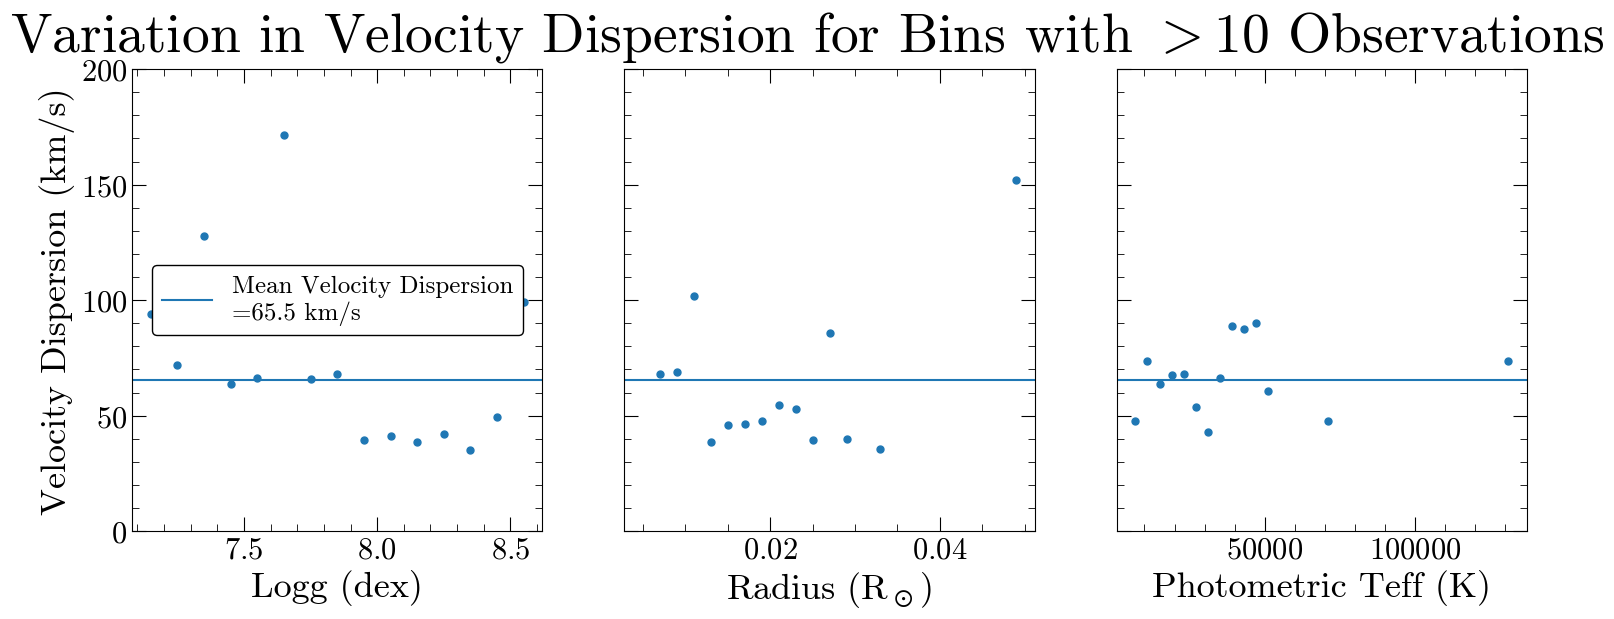

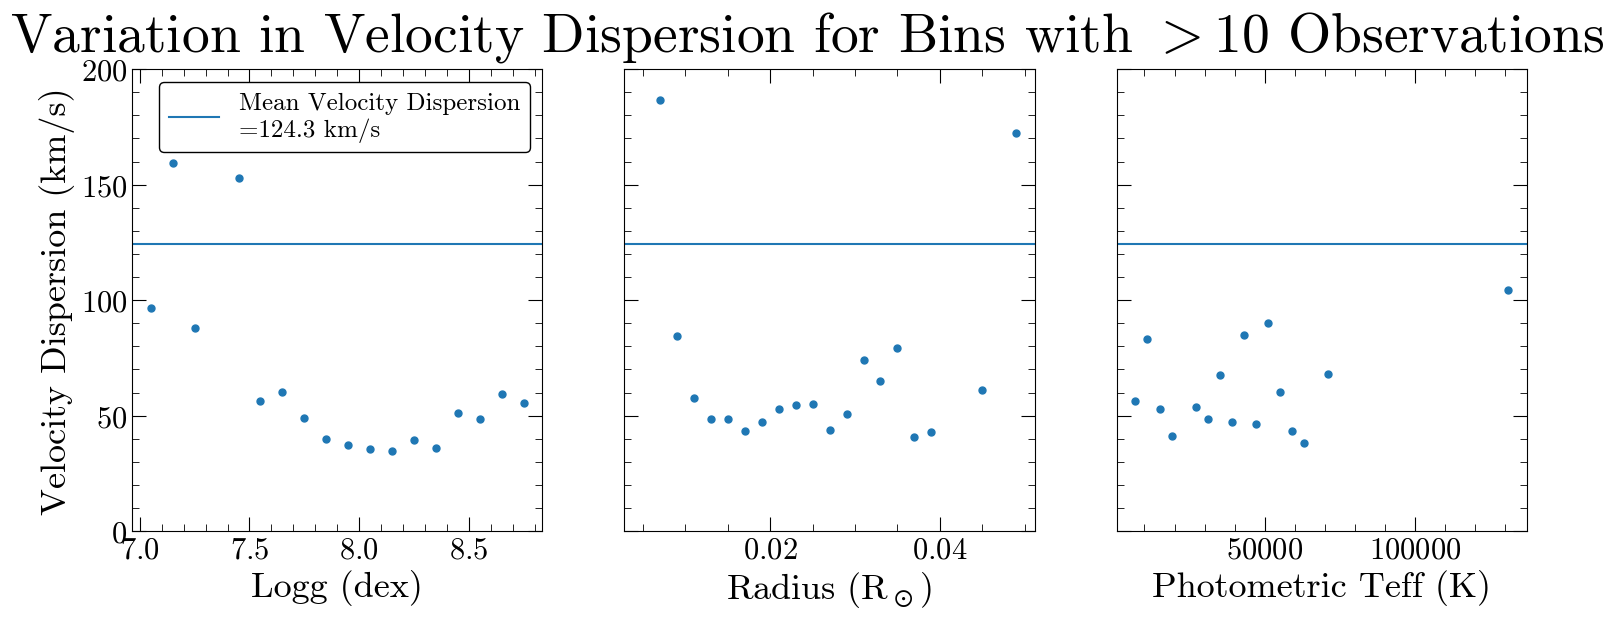

Temperature Dependence Sample
SDSSV
mean velocity= 33.25155245549317  km/s
velocity dispersion= 36.94524545058356  km/s
sigma^2= 1364.9511614038654

eSDSS
mean velocity= 27.043621807217797  km/s
velocity dispersion= 34.03208829761003  km/s
sigma^2= 1158.1830338963257


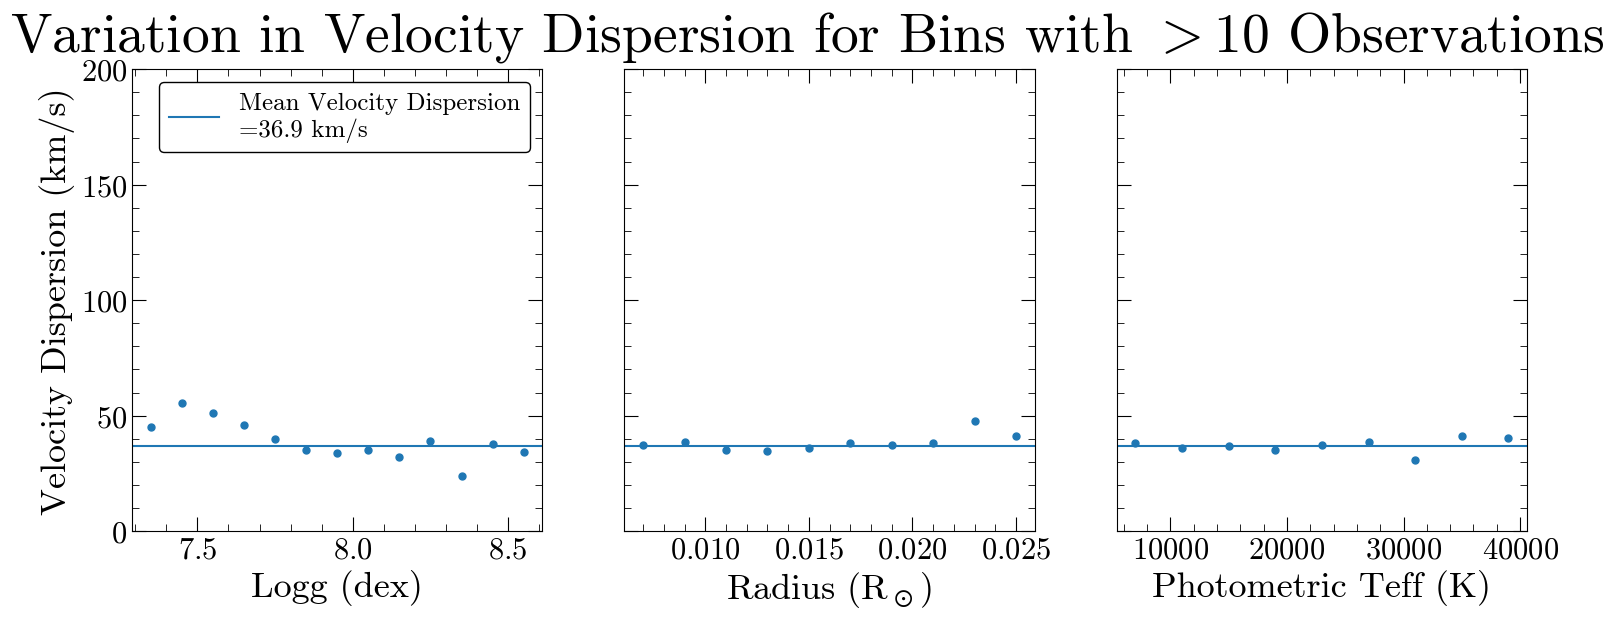

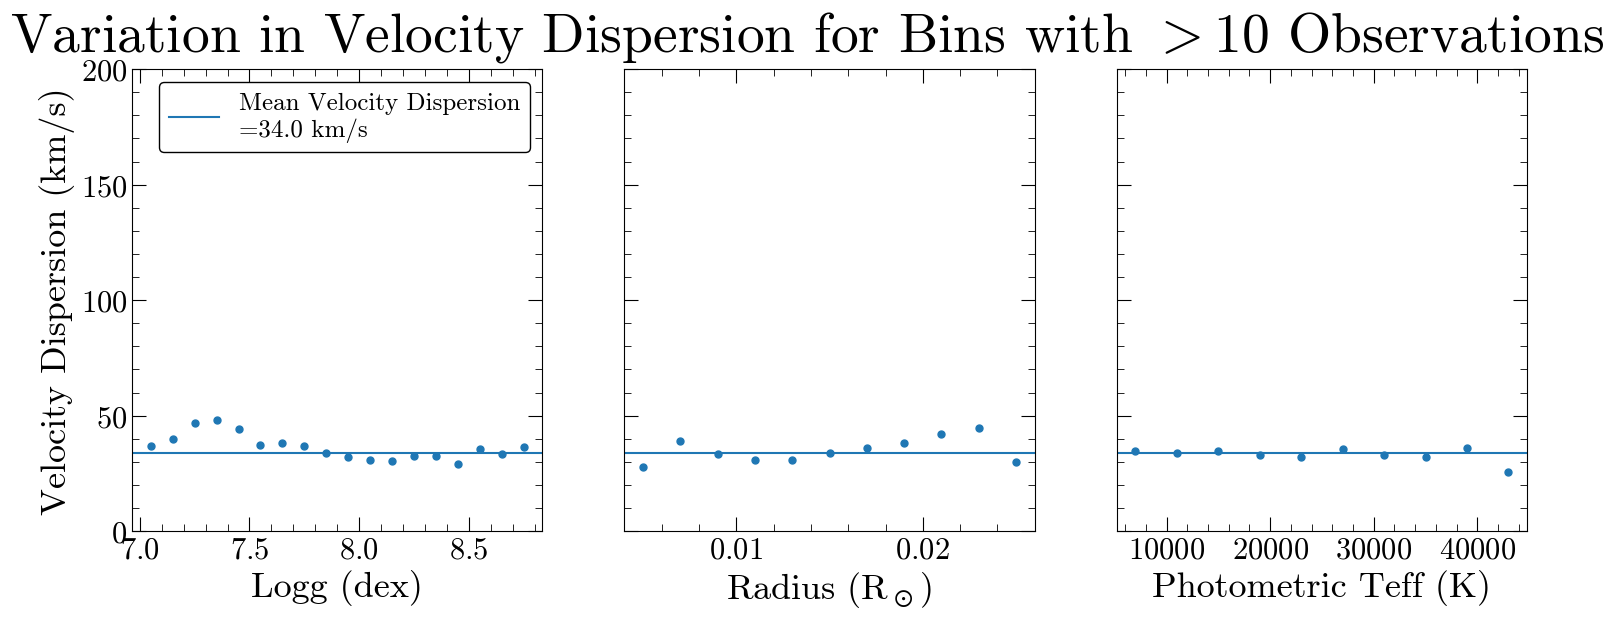

In [29]:
print('Full Sample')
#make quality cut of snr=10 to get relliable RVs
snr_cut=10
SDSSV_tab_cut=SDSSV_tab_unique.query('snr_coadd>@snr_cut')
eSDSS_tab_cut=eSDSS_tab_unique.query('snr_coadd>@snr_cut')
print('SDSSV')
SDSSV_full_sigma_v=velocity_dispersion(SDSSV_tab_cut,verbose=True,plot=True)
print('')
print('eSDSS')
eSDSS_full_sigma_v=velocity_dispersion(eSDSS_tab_cut,verbose=True,plot=True)
plt.show()

print('Temperature Dependence Sample')
SDSSV_tab_cut=SDSSV_tab_tempdep #tempdep samples already have snr>10 cut
eSDSS_tab_cut=eSDSS_tab_tempdep
print('SDSSV')
SDSSV_sigma_v=velocity_dispersion(SDSSV_tab_cut,verbose=True,plot=True)
print('')
print('eSDSS')
eSDSS_sigma_v=velocity_dispersion(eSDSS_tab_cut,verbose=True,plot=True)
plt.show()


### Turning velocity dispersion into asymmetric drift
- For the full sample with snr>10 cut
    - The overall velocity dispersion is ~ 65 km/s for SDSS-V amd ~124 km/s for eSDSS 
        - This is very different from the temperature dependence sample, showing the importance of measuring asymmetric drift for particular science cases with different selection effects picking out different populations of WDs
    - Binning in Logg/Radius/Teff results in dispersions varying between 30-190 km/s for bins with >10 entries.
        - Much higher velocity dispersions at low logg and small/large radii
  
- For the temperature dependence sample
    - The overall velocity dispersion is ~37 km/s for SDSS-V and ~34 km/s for eSDSS. 
        - SDSS-V has more WD observations in the galactic plane than eSDSS and had very different WD targeting strategies, possibily accounting for this offset.
    - Binning in Logg/Radius/Teff results in dispersions varying between 30-60 km/s for bins with >10 entries.
        - Overall, see no trend in velocity dispersion with Teff. See slight trend where lower mass (low logg, high radius) objects have higher asymmetric drift. This is possibly due to binary evolution as lower mass WDs more likely to be in binaries.

Fig. 3 of https://ui.adsabs.harvard.edu/abs/2010MNRAS.403.1829S/abstract plots asymmetric drift as a function of velocity dispersion squared.

### Our sigma_v^2 is ~1400km/s for SDSS-V and ~1200 km/s for eSDSS which correspond to an asymmetric drift of 10 and 8 km/s respectively.

### Apply the asymmetric drift correction

In [30]:
def asym_corr(table,asym_drift):
    #asym_drift=asymmetric drift in km/s
    
    #convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
    coords_cartesian=SkyCoord(l=table['l'].to_list()*u.deg, 
                       b=table['b'].to_list()*u.deg, 
                       distance=table['r_med_geo'].to_list()*u.pc,frame='galactic')
    coords_cartesian.representation_type = 'cartesian'
    
    
    #make a sky coord object with the WD spatial coordinates and the asymmetric drift
    sc_asym = SkyCoord(u=coords_cartesian.u.value*u.pc, 
                       v=coords_cartesian.v.value*u.pc, 
                       w=coords_cartesian.w.value*u.pc,
                       U=np.full(len(coords_cartesian),0)*u.km/u.s,
                       V=np.full(len(coords_cartesian),-asym_drift)*u.km/u.s,
                       W=np.full(len(coords_cartesian),0)*u.km/u.s,
                       representation_type=CartesianRepresentation,differential_type=CartesianDifferential,frame='galactic')
    #convert to LSR
    sc_asym_lsr=sc_asym.lsr
    
    #add the radial velocity correction due to asym drift to the RV_corv_LSR
    table['rv_corv_asym_corr']=table['rv_corv_lsr']+sc_asym_lsr.radial_velocity.value
    table['asym_corr']=sc_asym_lsr.radial_velocity.value
    
    return(table)

In [31]:
SDSSV_tab_tempdep=asym_corr(SDSSV_tab_tempdep,10)
eSDSS_tab_tempdep=asym_corr(eSDSS_tab_tempdep,8)

In [32]:
print(min(SDSSV_tab_tempdep['asym_corr']),max(SDSSV_tab_tempdep['asym_corr']))
print(min(eSDSS_tab_tempdep['asym_corr']),max(eSDSS_tab_tempdep['asym_corr']))

print(np.median(np.abs(SDSSV_tab_tempdep['asym_corr'])))
print(np.median(np.abs(eSDSS_tab_tempdep['asym_corr'])))

print(np.mean(SDSSV_tab_tempdep['asym_corr']))
print(np.mean(eSDSS_tab_tempdep['asym_corr']))

-13.445238072304251 13.420273942500149
-13.91324093875442 13.89496650251026
6.97676611803735
6.386303551498038
0.9828473982238186
2.0541176907490755


# Bin the temperature dependence sample

### By photometric radius

In [33]:
r_bins=np.round(np.arange(0,0.055,0.002),3)
print(r_bins)

#get the range and center for each bin
r_bin_ranges=[]
r_bin_centers=[]
for i in range(len(r_bins)-1):
    array=[r_bins[i],r_bins[i+1]]
    half=0.5*(r_bins[i]+r_bins[i+1])
    r_bin_ranges.append(array)
    r_bin_centers.append(half)
r_bin_nums=np.arange(0,len(r_bin_ranges))

#save the bin info
np.savez('csv/radius_bins',bins=r_bins,ranges=r_bin_ranges,centers=r_bin_centers,nums=r_bin_nums)

[0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022
 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.05  0.052 0.054]


Text(0.5, 1.0, 'eSDSS')

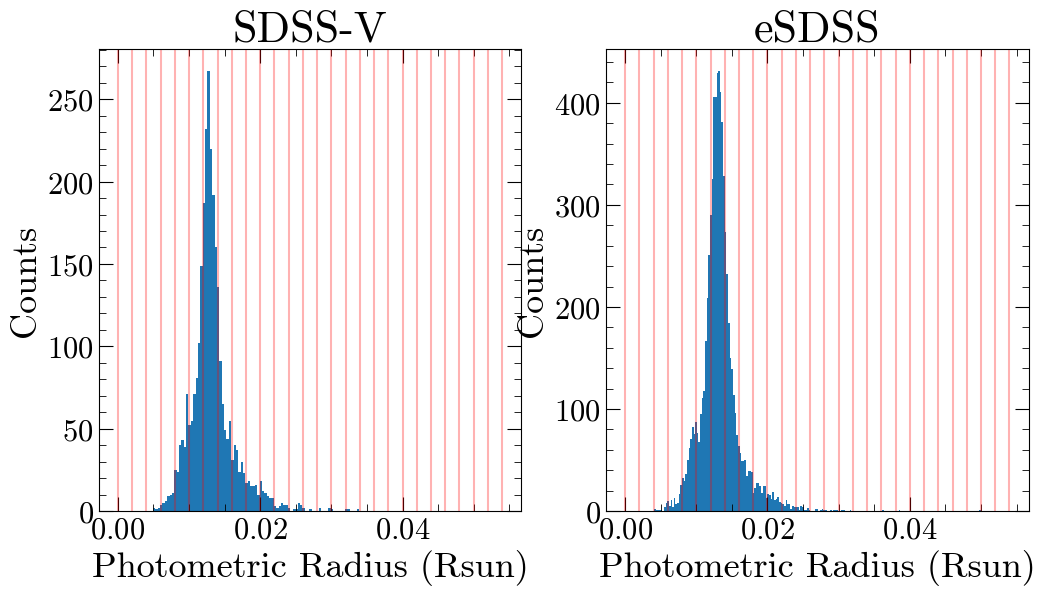

In [34]:
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(12,6))

ax1.hist(SDSSV_tab_tempdep['radius_phot'])
for i in range(len(r_bins)):
    ax1.axvline(x = r_bins[i], color = 'r',alpha=0.3)
ax1.set_xlabel(r'Photometric Radius (Rsun)')
ax1.set_ylabel(r'Counts')
ax1.set_title('SDSS-V')

ax2.hist(eSDSS_tab_tempdep['radius_phot'])
for i in range(len(r_bins)):
    ax2.axvline(x = r_bins[i], color = 'r',alpha=0.3)
ax2.set_xlabel(r'Photometric Radius (Rsun)')
ax2.set_ylabel(r'Counts')
ax2.set_title('eSDSS')

In [35]:
def bin_by_radius(table,verbose=False):
    #bin by radius
    r_bin_ids=[]
    r_bin_id_ranges=[]
    r_bin_id_centers=[]
    for i in range(len(table)):
        radius=table['radius_phot'][i]
        for j in range(len(r_bin_ranges)):
            if r_bin_ranges[j][0]<radius<r_bin_ranges[j][1]:
                r_bin_ids.append(j)
                r_bin_id_ranges.append(r_bin_ranges[j])
                r_bin_id_centers.append(r_bin_centers[j])
    table['radius_bin_id']=r_bin_ids
    table['radius_bin_range']=r_bin_id_ranges
    table['radius_bin_center']=r_bin_id_centers
    
    if verbose==True:
        for i in range(len(r_bin_ranges)):
            bin_num=r_bin_nums[i]
            bin_range=r_bin_ranges[i]
            tmp=table.query('radius_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' Rsun, Number of WDs in bin=',len(tmp))
            
    return(table)

In [36]:
SDSSV_tab_tempdep=bin_by_radius(SDSSV_tab_tempdep)
eSDSS_tab_tempdep=bin_by_radius(eSDSS_tab_tempdep)

### By spectroscopic Logg

In [37]:
g_bins=np.round(np.arange(7,9.1,0.1),1)
print(g_bins)

g_bin_ranges=[]
g_bin_centers=[]
for i in range(len(g_bins)-1):
    array=[g_bins[i],g_bins[i+1]]
    half=0.5*(g_bins[i]+g_bins[i+1])
    g_bin_ranges.append(array)
    g_bin_centers.append(half)
g_bin_nums=np.arange(0,len(g_bin_ranges))

#save the bin info
np.savez('csv/logg_bins',bins=g_bins,ranges=g_bin_ranges,centers=g_bin_centers,nums=g_bin_nums)

[7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7
 8.8 8.9 9. ]


Text(0.5, 1.0, 'eSDSS')

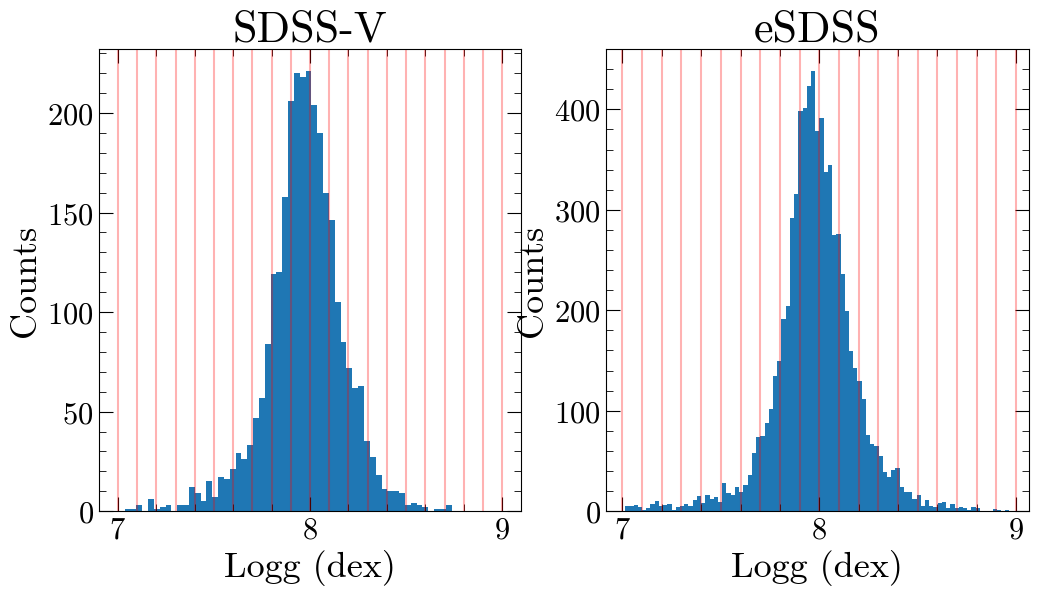

In [38]:
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(12,6))

ax1.hist(SDSSV_tab_tempdep['logg_prf_coadd'])
for i in range(len(g_bins)):
    ax1.axvline(x = g_bins[i], color = 'r',alpha=0.3)
ax1.set_xlabel(r'Logg (dex)')
ax1.set_ylabel(r'Counts')
ax1.set_title('SDSS-V')

ax2.hist(eSDSS_tab_tempdep['logg_prf_coadd'])
for i in range(len(g_bins)):
    ax2.axvline(x = g_bins[i], color = 'r',alpha=0.3)
ax2.set_xlabel(r'Logg (dex)')
ax2.set_ylabel(r'Counts')
ax2.set_title('eSDSS')


In [39]:
def bin_by_logg(table,verbose=False):
    #bin by logg
    
    g_bin_ids=[]
    g_bin_id_ranges=[]
    g_bin_id_centers=[]
    for i in range(len(table)):
        logg=table['logg_prf_coadd'][i]
        for j in range(len(g_bin_ranges)):
            if g_bin_ranges[j][0]<logg<=g_bin_ranges[j][1]:
                g_bin_ids.append(j)
                g_bin_id_ranges.append(g_bin_ranges[j])
                g_bin_id_centers.append(g_bin_centers[j])
    table['logg_bin_id']=g_bin_ids
    table['logg_bin_range']=g_bin_id_ranges
    table['logg_bin_center']=g_bin_id_centers
    
    if verbose==True:
        for i in range(len(g_bin_ranges)):
            bin_num=g_bin_nums[i]
            bin_range=g_bin_ranges[i]
            tmp=table.query('logg_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' dex, Number of WDs in bin=',len(tmp))
    return(table)

In [40]:
SDSSV_tab_tempdep=bin_by_logg(SDSSV_tab_tempdep)
eSDSS_tab_tempdep=bin_by_logg(eSDSS_tab_tempdep)

# Save the tables
Save separate tables for SDSSV and eSDSS, also save combined table

In [41]:
SDSSV_tab_tempdep.to_csv('csv/SDSSV_tempdep_sample.csv',index=False)
eSDSS_tab_tempdep.to_csv('csv/eSDSS_tempdep_sample.csv',index=False)

In [42]:
#combine and save

#add flag for whether object is SDSS-V or early SDSS
SDSSV_tab_tempdep['sdssv_flag']=np.full(len(SDSSV_tab_tempdep),True)
eSDSS_tab_tempdep['sdssv_flag']=np.full(len(eSDSS_tab_tempdep),False)

#combine the data sets
tab_tempdep=SDSSV_tab_tempdep.append(eSDSS_tab_tempdep)
#reset the indices
indices=np.arange(0,len(tab_tempdep))
tab_tempdep.set_index(indices,inplace=True)
#save as .csv
tab_tempdep.to_csv('csv/tempdep_sample.csv',index=False)


/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_73478/3762361040.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_tempdep=SDSSV_tab_tempdep.append(eSDSS_tab_tempdep)


In [43]:
#get overlap between SDSS-V and eSDSS
print(len(tab_tempdep)-len(tab_tempdep.drop_duplicates(subset='gaia_dr3_source_id')))

723


# Add flag indicating whether object was used in temperature dependence sample and asymmetric drift corrected RVs to the full sample dataframes

In [44]:
#SDSSV_tab=SDSSV_tab.drop(['rv_corv_asym_corr','asym_corr','tempdep_catalog_flag'],axis=1)
#eSDSS_tab=eSDSS_tab.drop(['rv_corv_asym_corr','asym_corr','tempdep_catalog_flag'],axis=1)


In [45]:
SDSSV_tab_tempdep_merge=SDSSV_tab_tempdep[['gaia_dr3_source_id','rv_corv_asym_corr','asym_corr']]
eSDSS_tab_tempdep_merge=eSDSS_tab_tempdep[['gaia_dr3_source_id','rv_corv_asym_corr','asym_corr']]

SDSSV_tab_tempdep_merge['tempdep_catalog_flag']=np.full(len(SDSSV_tab_tempdep_merge),True)
eSDSS_tab_tempdep_merge['tempdep_catalog_flag']=np.full(len(eSDSS_tab_tempdep_merge),True)

SDSSV_tab=pd.merge(left=SDSSV_tab,right=SDSSV_tab_tempdep_merge,on='gaia_dr3_source_id',how="outer")
#replace all nans in flag columns with False
SDSSV_tab['tempdep_catalog_flag']=SDSSV_tab['tempdep_catalog_flag'].fillna(False)

eSDSS_tab=pd.merge(left=eSDSS_tab,right=eSDSS_tab_tempdep_merge,on='gaia_dr3_source_id',how="outer")
#replace all nans in flag columns with False
eSDSS_tab['tempdep_catalog_flag']=eSDSS_tab['tempdep_catalog_flag'].fillna(False)

#save as .csv
SDSSV_tab.to_csv('csv/SDSSV_DA_df.csv',index=False)
eSDSS_tab.to_csv('csv/eSDSS_DA_df.csv',index=False)

#save to backup
SDSSV_tab.to_csv('csv/SDSSV_DA_df_nb06.csv',index=False)
eSDSS_tab.to_csv('csv/eSDSS_DA_df_nb06.csv',index=False)

# Save the final catalogs as .fits files to be published as a SDSS Value Added Catalog (VAC)

In [48]:
#drop unnecessary columns and re-order columns
SDSSV_tab_dropped=SDSSV_tab[['gaia_dr3_source_id','fieldid','mjd','catalogid','snr','p_da','ra','dec','l','b','r_med_geo','r_lo_geo','r_hi_geo',
                            'pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_flux','phot_g_mean_flux_error',
                            'phot_g_mean_mag','phot_bp_mean_flux','phot_bp_mean_flux_error','phot_bp_mean_mag','phot_rp_mean_flux',
                            'phot_rp_mean_flux_error','phot_rp_mean_mag','phot_bp_rp_excess_factor','no_gaia_phot','clean',
                            'psf_mag_u','psf_mag_g','psf_mag_r','psf_mag_i','psf_mag_z','psf_magerr_u','psf_magerr_g',
                            'psf_magerr_r','psf_magerr_i','psf_magerr_z','psf_flux_u','psf_flux_g','psf_flux_r','psf_flux_i',
                            'psf_flux_z','psf_fluxivar_u','psf_fluxivar_g','psf_fluxivar_r','psf_fluxivar_i','psf_fluxivar_z',
                            'mag_ab_u','magerr_ab_u','mag_ab_g','magerr_ab_g','mag_ab_r','magerr_ab_r','mag_ab_i','magerr_ab_i',
                            'mag_ab_z','magerr_ab_z','no_sdss_phot','rv_falcon','e_rv_falcon','falcon_flag','logg_raddi',
                            'e_logg_raddi','mass_raddi','e_mass_raddi','radius_raddi','rv_raddi','e_rv_raddi','teff_raddi','e_teff_raddi',
                            'e_radius_raddi','raddi_flag','teff_anguiano','e_teff_anguiano','mass_anguiano','e_mass_anguiano','logg_anguiano',
                            'e_logg_anguiano','rv_anguiano','e_rv_anguiano','radius_anguiano','e_radius_anguiano','anguiano_flag',
                            'teff_gentile','e_teff_gentile','logg_gentile','e_logg_gentile','mass_gentile','e_mass_gentile','radius_gentile',
                            'e_radius_gentile','gentile_flag','teff_koester','e_teff_koester','logg_koester','e_logg_koester','koester_flag',
                            'teff_kepler','e_teff_kepler','logg_kepler','e_logg_kepler','rv_kepler','e_rv_kepler','mass_kepler',
                            'e_mass_kepler','radius_kepler','e_radius_kepler','kepler_flag','snr_coadd','nspec_coadd',
                            'rv_corv_ind','e_rv_corv_ind','teff_corv_ind',
                            'logg_corv_ind','rv_corv_coadd','e_rv_corv_coadd','teff_corv_coadd','logg_corv_coadd',
                            'e_rv_corv_ind_full','e_rv_corv_coadd_full','rv_corv_mean','e_rv_corv_mean','nspec_mean_rv_corv','teff_prf_ind',
                            'e_teff_prf_ind','logg_prf_ind','e_logg_prf_ind','teff_prf_coadd','e_teff_prf_coadd','logg_prf_coadd',
                            'e_logg_prf_coadd','e_teff_prf_ind_full','e_logg_prf_ind_full','e_teff_prf_coadd_full','e_logg_prf_coadd_full',
                            'teff_prf_mean','e_teff_prf_mean','logg_prf_mean','e_logg_prf_mean','nspec_mean_teff','nspec_mean_logg',
                            'av_lo','u_ext_lo','g_ext_lo','r_ext_lo','i_ext_lo','z_ext_lo','gaia_g_ext_lo','gaia_bp_ext_lo','gaia_rp_ext_lo',
                            'u_dered_lo','g_dered_lo','r_dered_lo','i_dered_lo','z_dered_lo','gaia_g_dered_lo','gaia_bp_dered_lo',
                            'gaia_rp_dered_lo','av_med','u_ext_med','g_ext_med','r_ext_med','i_ext_med','z_ext_med','gaia_g_ext_med',
                            'gaia_bp_ext_med','gaia_rp_ext_med','u_dered_med','g_dered_med','r_dered_med','i_dered_med','z_dered_med',
                            'gaia_g_dered_med','gaia_bp_dered_med','gaia_rp_dered_med','av_hi','u_ext_hi','g_ext_hi','r_ext_hi','i_ext_hi',
                            'z_ext_hi','gaia_g_ext_hi','gaia_bp_ext_hi','gaia_rp_ext_hi','u_dered_hi','g_dered_hi','r_dered_hi','i_dered_hi',
                            'z_dered_hi','gaia_g_dered_hi','gaia_bp_dered_hi','gaia_rp_dered_hi','phot_used','phot_radius_sdss_lo',
                            'e_phot_radius_sdss_lo','phot_teff_sdss_lo','e_phot_teff_sdss_lo','phot_redchi_sdss_lo','phot_radius_gaia_lo',
                            'e_phot_radius_gaia_lo','phot_teff_gaia_lo','e_phot_teff_gaia_lo','phot_redchi_gaia_lo','phot_radius_sdss_med',
                            'e_phot_radius_sdss_med','phot_teff_sdss_med','e_phot_teff_sdss_med','phot_redchi_sdss_med','phot_radius_gaia_med',
                            'e_phot_radius_gaia_med','phot_teff_gaia_med','e_phot_teff_gaia_med','phot_redchi_gaia_med','phot_radius_sdss_hi',
                            'e_phot_radius_sdss_hi','phot_teff_sdss_hi','e_phot_teff_sdss_hi','phot_redchi_sdss_hi','phot_radius_gaia_hi',
                            'e_phot_radius_gaia_hi','phot_teff_gaia_hi','e_phot_teff_gaia_hi','phot_redchi_gaia_hi','phot_logg_sdss_lo','e_phot_logg_sdss_lo','sdss_logg_flag_lo',
                            'gaia_logg_flag_lo','phot_logg_sdss_med','e_phot_logg_sdss_med','sdss_logg_flag_med','gaia_logg_flag_med',
                            'phot_logg_sdss_hi','e_phot_logg_sdss_hi','sdss_logg_flag_hi','gaia_logg_flag_hi',
                            'radius_phot_sdss','e_radius_phot_sdss','radius_phot_gaia','e_radius_phot_gaia','teff_phot_sdss',
                            'e_teff_phot_sdss','teff_phot_gaia','e_teff_phot_gaia','phot_err_sdss','phot_err_gaia',
                            'radius_phot','e_radius_phot','teff_phot','e_teff_phot','e_radius_phot_full','e_teff_phot_full','mass_rad_logg',
                            'e_mass_rad_logg','mass_logg_theory','e_mass_logg_theory','mass_rad_theory','e_mass_rad_theory','rv_corv_lsr',
                            'rv_corv_asym_corr','asym_corr','tempdep_catalog_flag']]

eSDSS_tab_dropped=eSDSS_tab[['gaia_dr3_source_id','plate','mjd','fiber','snr','spec_avail','ra','dec','l','b','r_med_geo','r_lo_geo','r_hi_geo',
                            'pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_flux','phot_g_mean_flux_error',
                            'phot_g_mean_mag','phot_bp_mean_flux','phot_bp_mean_flux_error','phot_bp_mean_mag','phot_rp_mean_flux',
                            'phot_rp_mean_flux_error','phot_rp_mean_mag','phot_bp_rp_excess_factor','no_gaia_phot','clean',
                            'psf_mag_u','psf_mag_g','psf_mag_r','psf_mag_i','psf_mag_z','psf_magerr_u','psf_magerr_g',
                            'psf_magerr_r','psf_magerr_i','psf_magerr_z','psf_flux_u','psf_flux_g','psf_flux_r','psf_flux_i',
                            'psf_flux_z','psf_fluxivar_u','psf_fluxivar_g','psf_fluxivar_r','psf_fluxivar_i','psf_fluxivar_z',
                            'mag_ab_u','magerr_ab_u','mag_ab_g','magerr_ab_g','mag_ab_r','magerr_ab_r','mag_ab_i','magerr_ab_i',
                            'mag_ab_z','magerr_ab_z','no_sdss_phot',
                            'teff_gentile','e_teff_gentile','logg_gentile','e_logg_gentile','mass_gentile','e_mass_gentile','radius_gentile',
                            'e_radius_gentile','sdss_dr','teff_sdss_dr','e_teff_sdss_dr','logg_sdss_dr','e_logg_sdss_dr','teff1d_sdss_dr',
                            'e_teff1d_sdss_dr','logg1d_sdss_dr','e_logg1d_sdss_dr','rv_sdss_dr','e_rv_sdss_dr','mass_sdss_dr','e_mass_sdss_dr',
                            'mass1d_sdss_dr','e_mass1d_sdss_dr','radius_sdss_dr','e_radius_sdss_dr','radius1d_sdss_dr','e_radius1d_sdss_dr',
                            'snr_coadd','nspec_coadd',
                            'rv_corv_ind','e_rv_corv_ind','teff_corv_ind',
                            'logg_corv_ind','rv_corv_coadd','e_rv_corv_coadd','teff_corv_coadd','logg_corv_coadd',
                            'e_rv_corv_ind_full','e_rv_corv_coadd_full','rv_corv_mean','e_rv_corv_mean','nspec_mean_rv_corv','teff_prf_ind',
                            'e_teff_prf_ind','logg_prf_ind','e_logg_prf_ind','teff_prf_coadd','e_teff_prf_coadd','logg_prf_coadd',
                            'e_logg_prf_coadd','e_teff_prf_ind_full','e_logg_prf_ind_full','e_teff_prf_coadd_full','e_logg_prf_coadd_full',
                            'teff_prf_mean','e_teff_prf_mean','logg_prf_mean','e_logg_prf_mean','nspec_mean_teff','nspec_mean_logg',
                            'av_lo','u_ext_lo','g_ext_lo','r_ext_lo','i_ext_lo','z_ext_lo','gaia_g_ext_lo','gaia_bp_ext_lo','gaia_rp_ext_lo',
                            'u_dered_lo','g_dered_lo','r_dered_lo','i_dered_lo','z_dered_lo','gaia_g_dered_lo','gaia_bp_dered_lo',
                            'gaia_rp_dered_lo','av_med','u_ext_med','g_ext_med','r_ext_med','i_ext_med','z_ext_med','gaia_g_ext_med',
                            'gaia_bp_ext_med','gaia_rp_ext_med','u_dered_med','g_dered_med','r_dered_med','i_dered_med','z_dered_med',
                            'gaia_g_dered_med','gaia_bp_dered_med','gaia_rp_dered_med','av_hi','u_ext_hi','g_ext_hi','r_ext_hi','i_ext_hi',
                            'z_ext_hi','gaia_g_ext_hi','gaia_bp_ext_hi','gaia_rp_ext_hi','u_dered_hi','g_dered_hi','r_dered_hi','i_dered_hi',
                            'z_dered_hi','gaia_g_dered_hi','gaia_bp_dered_hi','gaia_rp_dered_hi','phot_used','phot_radius_sdss_lo',
                            'e_phot_radius_sdss_lo','phot_teff_sdss_lo','e_phot_teff_sdss_lo','phot_redchi_sdss_lo','phot_radius_gaia_lo',
                            'e_phot_radius_gaia_lo','phot_teff_gaia_lo','e_phot_teff_gaia_lo','phot_redchi_gaia_lo','phot_radius_sdss_med',
                            'e_phot_radius_sdss_med','phot_teff_sdss_med','e_phot_teff_sdss_med','phot_redchi_sdss_med','phot_radius_gaia_med',
                            'e_phot_radius_gaia_med','phot_teff_gaia_med','e_phot_teff_gaia_med','phot_redchi_gaia_med','phot_radius_sdss_hi',
                            'e_phot_radius_sdss_hi','phot_teff_sdss_hi','e_phot_teff_sdss_hi','phot_redchi_sdss_hi','phot_radius_gaia_hi',
                            'e_phot_radius_gaia_hi','phot_teff_gaia_hi','e_phot_teff_gaia_hi','phot_redchi_gaia_hi','phot_logg_sdss_lo','e_phot_logg_sdss_lo','sdss_logg_flag_lo',
                            'gaia_logg_flag_lo','phot_logg_sdss_med','e_phot_logg_sdss_med','sdss_logg_flag_med','gaia_logg_flag_med',
                            'phot_logg_sdss_hi','e_phot_logg_sdss_hi','sdss_logg_flag_hi','gaia_logg_flag_hi',
                            'radius_phot_sdss','e_radius_phot_sdss','radius_phot_gaia','e_radius_phot_gaia','teff_phot_sdss',
                            'e_teff_phot_sdss','teff_phot_gaia','e_teff_phot_gaia','phot_err_sdss','phot_err_gaia',
                            'radius_phot','e_radius_phot','teff_phot','e_teff_phot','e_radius_phot_full','e_teff_phot_full','mass_rad_logg',
                            'e_mass_rad_logg','mass_logg_theory','e_mass_logg_theory','mass_rad_theory','e_mass_rad_theory','rv_corv_lsr',
                            'rv_corv_asym_corr','asym_corr','tempdep_catalog_flag']]

#convert to astropy table
SDSSV_astpy=Table.from_pandas(SDSSV_tab_dropped)
eSDSS_astpy=Table.from_pandas(eSDSS_tab_dropped)

#write to .fits file
SDSSV_astpy.write('SDSSV_DA_df.fits', format='fits')#,overwrite=True)
eSDSS_astpy.write('eSDSS_DA_df.fits', format='fits')#,overwrite=True)

# Read back in final tables

In [49]:
SDSSV_tab_tempdep=pd.read_csv('csv/SDSSV_tempdep_sample.csv')
eSDSS_tab_tempdep=pd.read_csv('csv/eSDSS_tempdep_sample.csv')

In [50]:
print(np.median(SDSSV_tab_tempdep['e_radius_phot_full']))
print(np.median(SDSSV_tab_tempdep['e_logg_prf_coadd_full']))

0.0015710097131647
0.1314987003157773


In [51]:
np.median(SDSSV_tab_tempdep['snr_coadd'])

21.8592529296875

In [52]:
SDSSV_tab=pd.read_csv('csv/SDSSV_DA_df.csv')
eSDSS_tab=pd.read_csv('csv/eSDSS_DA_df.csv')

In [53]:
#read back in
SDSSV_astpy = Table.read('SDSSV_DA_df.fits')
eSDSS_astpy = Table.read('eSDSS_DA_df.fits')

# Look into SDSS-V vs eSDSS distributions
Both for the full catalog and for the temperature dependence catalog

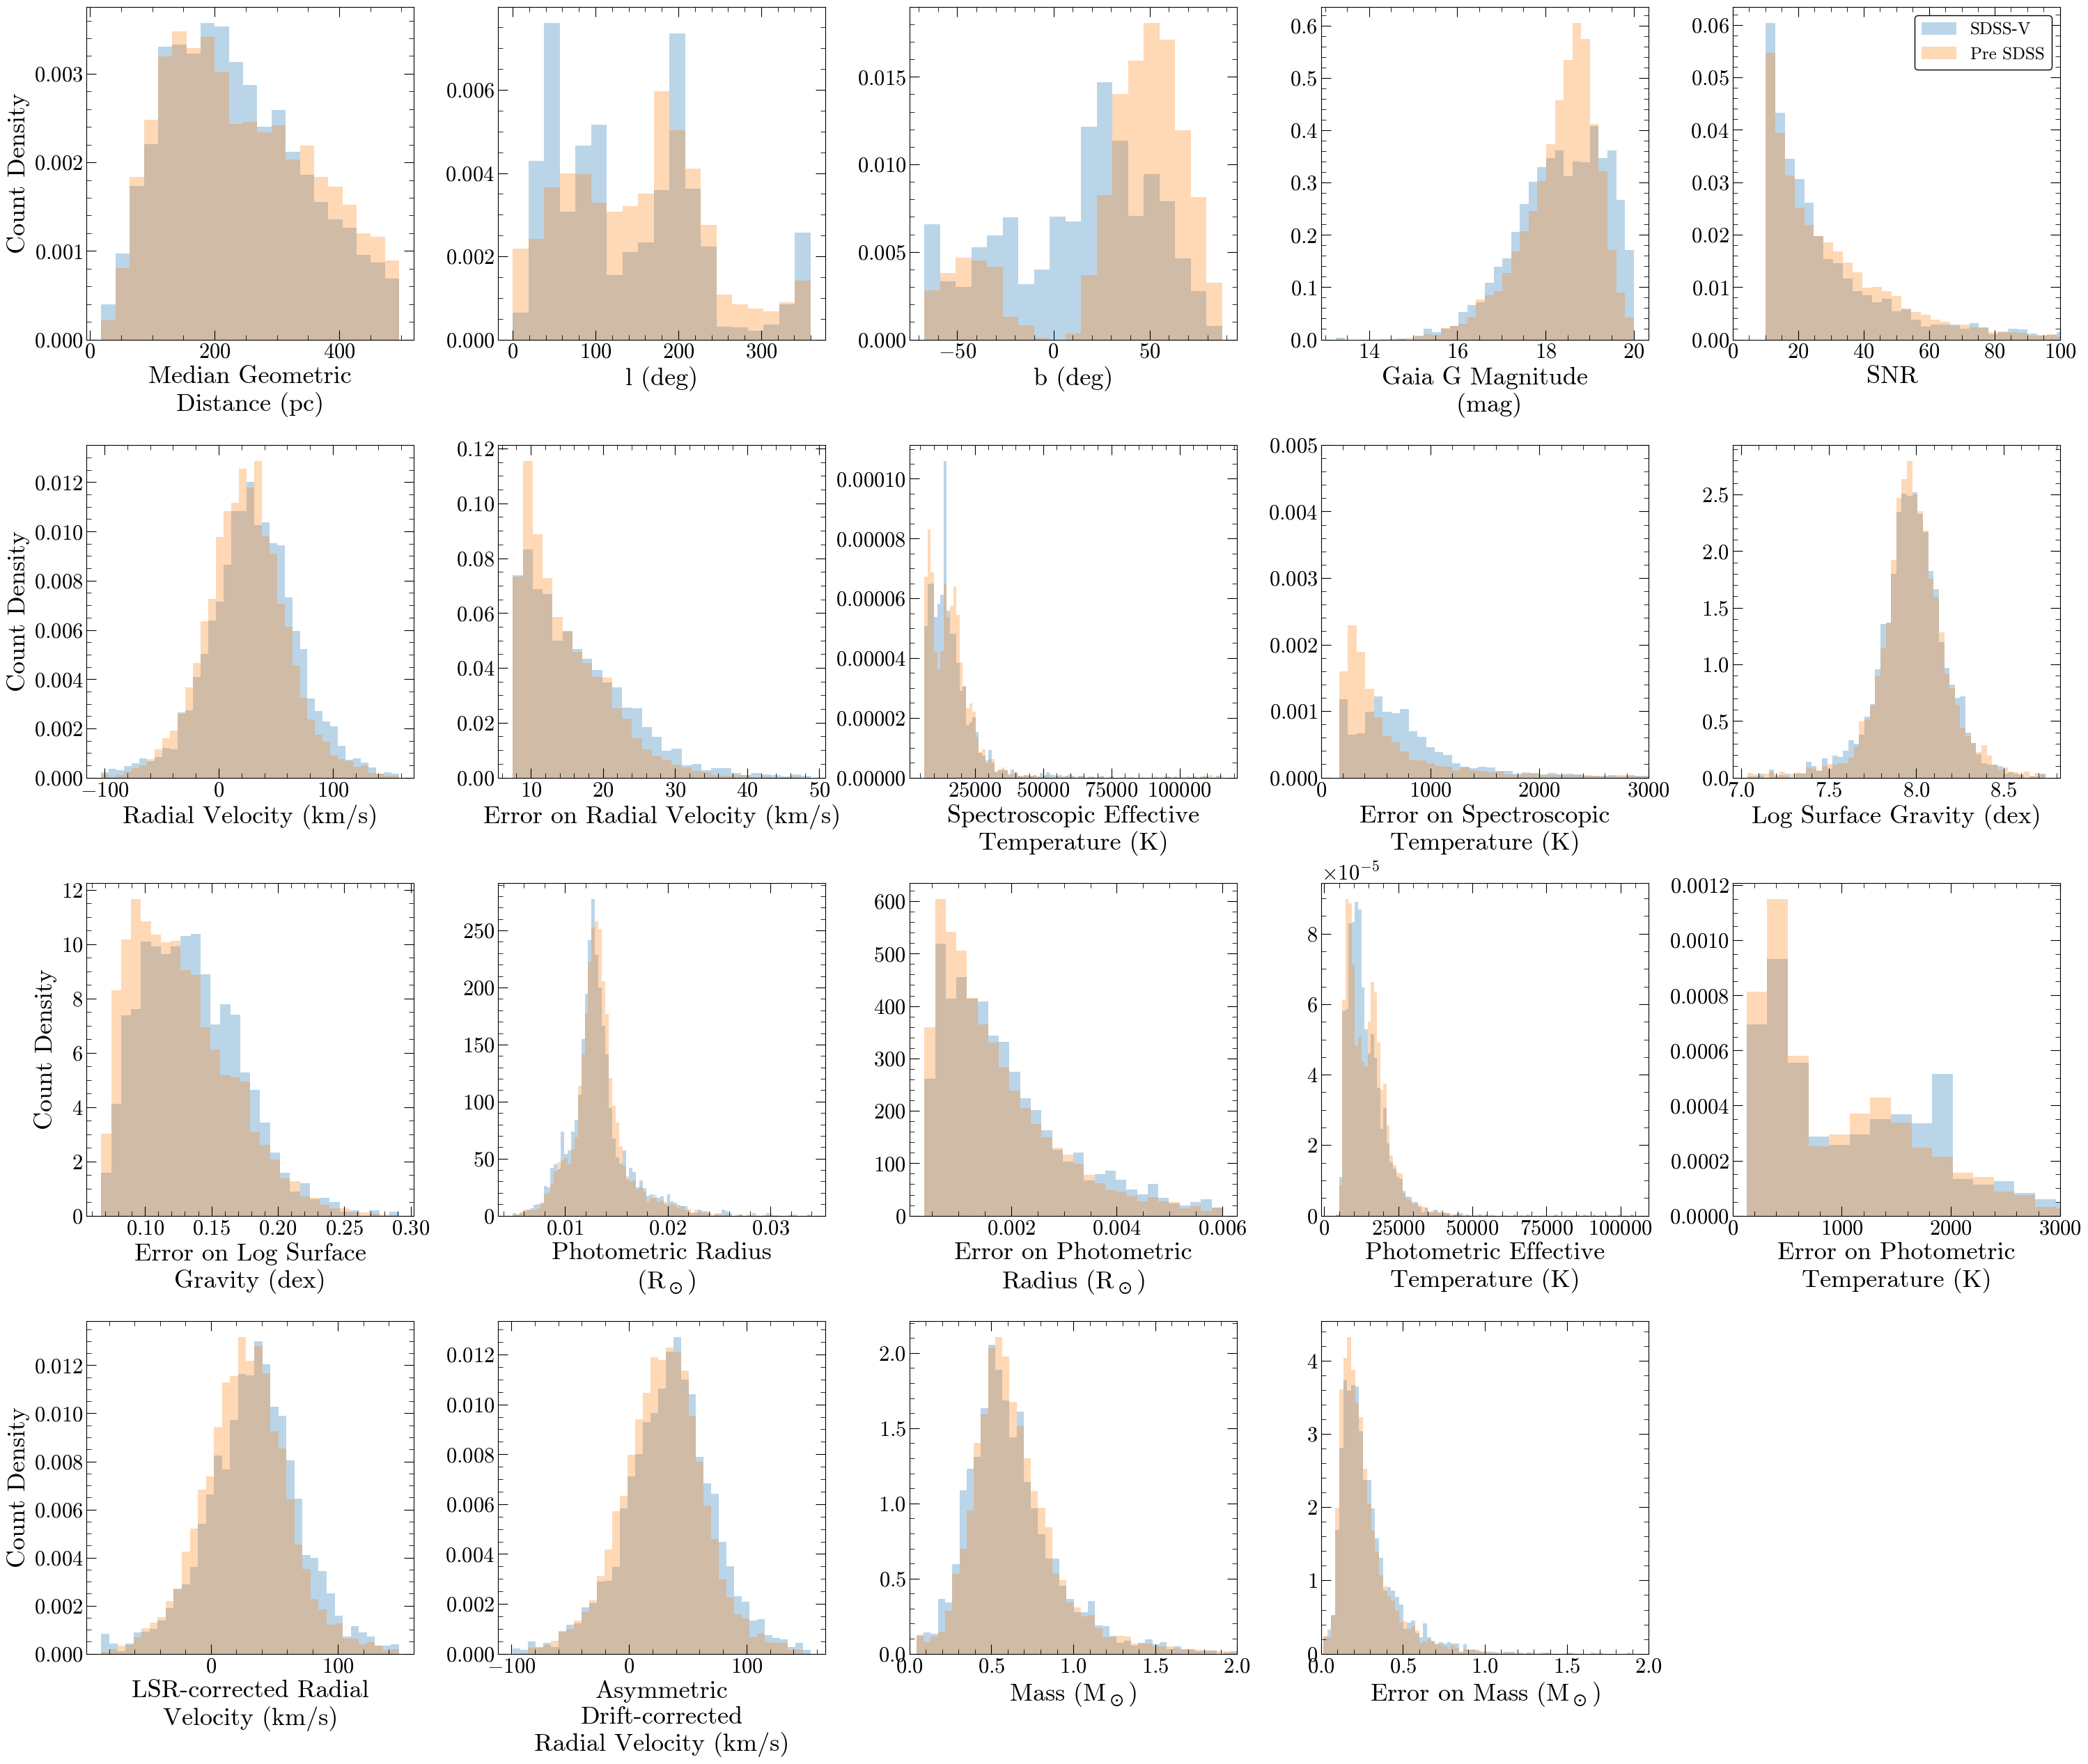

In [54]:
cols=['r_med_geo','l','b','phot_g_mean_mag','snr_coadd','rv_corv_coadd','e_rv_corv_coadd_full','teff_prf_coadd',
      'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','radius_phot','e_radius_phot_full',
      'teff_phot','e_teff_phot_full','rv_corv_lsr','rv_corv_asym_corr','mass_rad_logg','e_mass_rad_logg']
col_names=['Median Geometric\nDistance','l','b','Gaia G Magnitude\n','SNR','Radial Velocity','Error on Radial Velocity','Spectroscopic Effective\nTemperature',
           'Error on Spectroscopic\nTemperature', 'Log Surface Gravity', 'Error on Log Surface\nGravity',
           'Photometric Radius\n','Error on Photometric\nRadius','Photometric Effective\nTemperature',
           'Error on Photometric\nTemperature','LSR-corrected Radial\nVelocity',
           'Asymmetric\nDrift-corrected\nRadial Velocity','Mass','Error on Mass']
units=['(pc)','(deg)','(deg)','(mag)','','(km/s)','(km/s)','(K)','(K)','(dex)','(dex)','($R_\odot$)','($R_\odot$)','(K)','(K)','(km/s)','(km/s)','($M_\odot$)','($M_\odot$)']
lims=[0,0,0,0,[0,100],0,0,0,[0,3000],0,0,0,0,0,[0,3000],0,0,[0,2],[0,2]]

fig= plt.figure(figsize=(30,30))
plt.style.use('stefan.mplstyle')

plotnum=1
for i in range(len(cols)):
        fig.add_subplot(5,5,int(plotnum))
        (n, bins, patches) =plt.hist(SDSSV_tab_tempdep[cols[i]],density=True,alpha=0.3,label='SDSS-V')
        plt.hist(eSDSS_tab_tempdep[cols[i]],bins=bins,density=True,alpha=0.3,label='Pre SDSS')
        plt.xlabel(col_names[i]+' '+units[i])
        try:
            plt.xlim(lims[i][0],lims[i][1])
        except:
            pass
        plotnum=plotnum+1
        if i==4:
            plt.legend() 
        if i==8:
            plt.ylim(0,0.005)
        if i in (0,5,10,15):
            plt.ylabel('Count Density')
fig.tight_layout(pad=0.1)   

plt.savefig('SDSSV_vs_eSDSS_dist_tempdep.pdf')#,pad_inches=0.3)


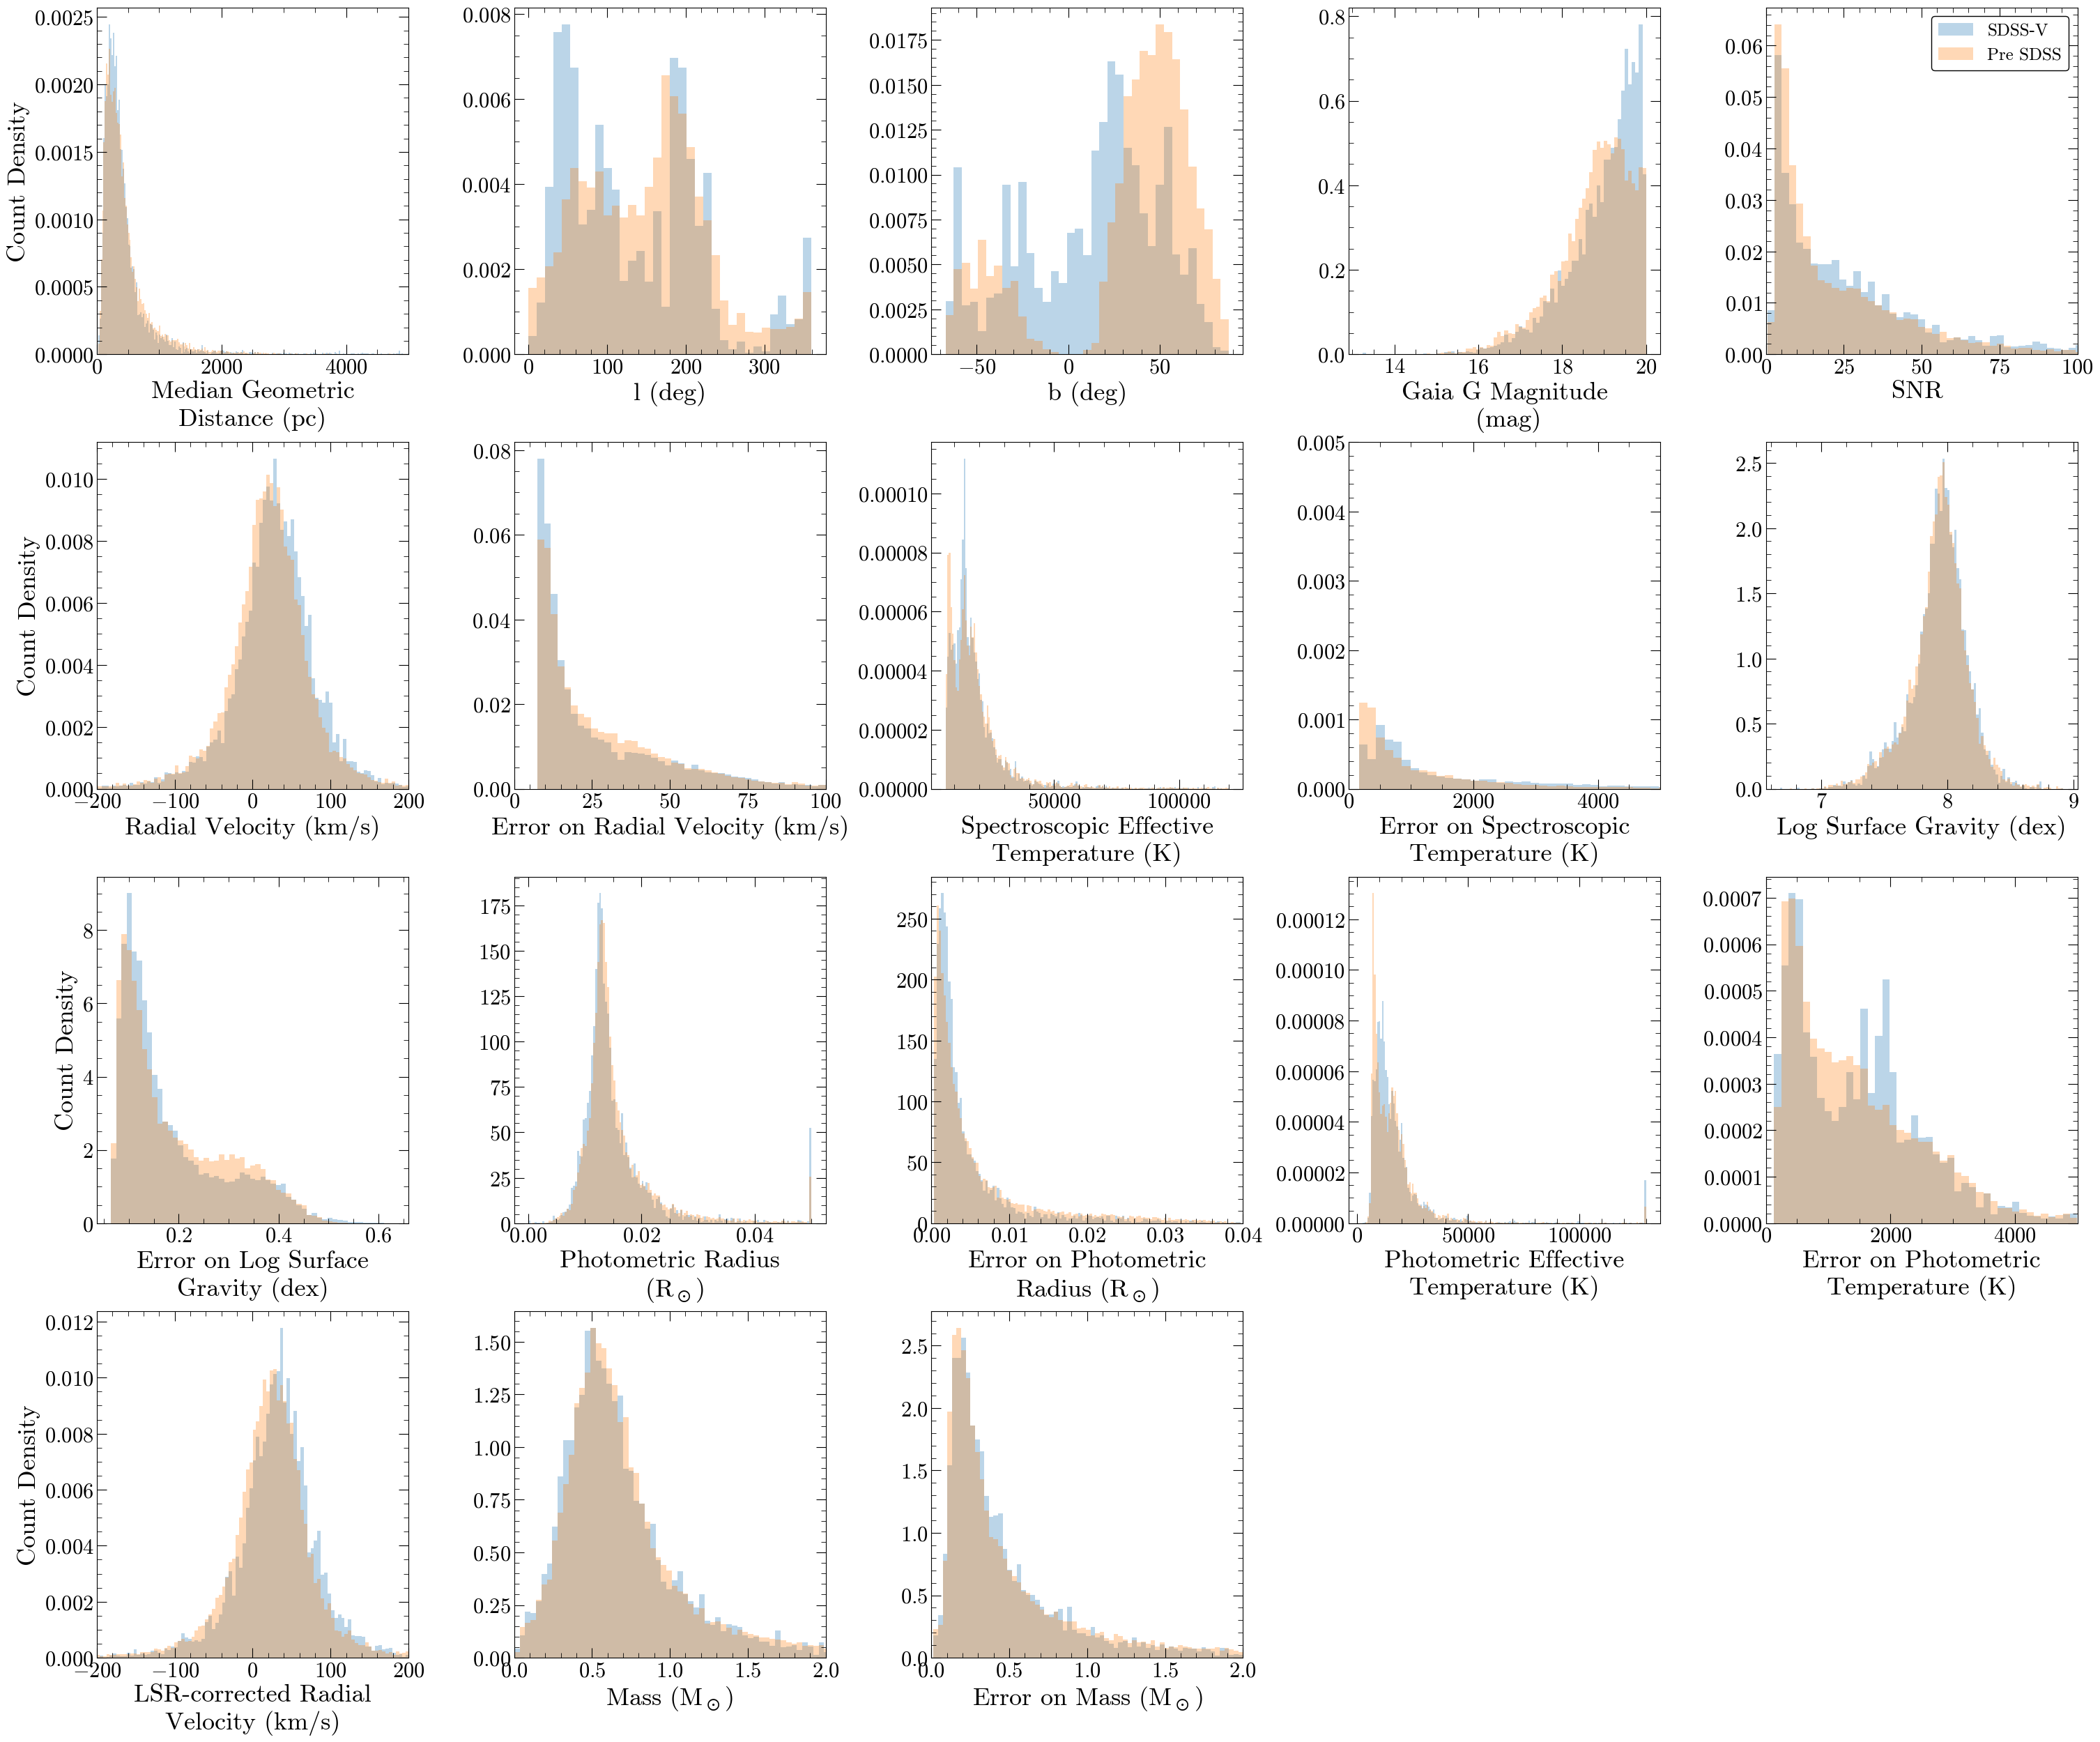

In [55]:
cols=['r_med_geo','l','b','phot_g_mean_mag','snr_coadd','rv_corv_coadd','e_rv_corv_coadd_full','teff_prf_coadd',
      'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','radius_phot','e_radius_phot_full',
      'teff_phot','e_teff_phot_full','rv_corv_lsr','mass_rad_logg','e_mass_rad_logg']
col_names=['Median Geometric\nDistance','l','b','Gaia G Magnitude\n','SNR','Radial Velocity','Error on Radial Velocity','Spectroscopic Effective\nTemperature',
           'Error on Spectroscopic\nTemperature', 'Log Surface Gravity', 'Error on Log Surface\nGravity',
           'Photometric Radius\n','Error on Photometric\nRadius','Photometric Effective\nTemperature',
           'Error on Photometric\nTemperature','LSR-corrected Radial\nVelocity','Mass','Error on Mass']
units=['(pc)','(deg)','(deg)','(mag)','','(km/s)','(km/s)','(K)','(K)','(dex)','(dex)','($R_\odot$)','($R_\odot$)','(K)','(K)','(km/s)','($M_\odot$)','($M_\odot$)']
lims=[[0,5000],0,0,0,[0,100],[-200,200],[0,100],0,[0,5000],0,0,0,[0,0.04],0,[0,5000],[-200,200],[0,2],[0,2]]

fig= plt.figure(figsize=(30,30))
plt.style.use('stefan.mplstyle')

plotnum=1
for i in range(len(cols)):
    fig.add_subplot(5,5,int(plotnum))
    if i==12 or i==14 or i==17:
        #the dispersion in values is tripping up the histogram plotting software
        #pre-restrict the range of values
        col=cols[i]
        min_val=lims[i][0]
        max_val=lims[i][1]
        (n, bins, patches) =plt.hist(SDSSV_tab.query("{1}<`{0}` & `{0}`<{2}".format(col,min_val,max_val))[cols[i]],density=True,alpha=0.3,label='SDSS-V')
        plt.hist(eSDSS_tab.query("{1}<`{0}` & `{0}`<{2}".format(col,min_val,max_val))[cols[i]],bins=bins,density=True,alpha=0.3,label='Pre SDSS')
    else:
        (n, bins, patches) =plt.hist(SDSSV_tab[cols[i]],density=True,alpha=0.3,label='SDSS-V')
        plt.hist(eSDSS_tab[cols[i]],bins=bins,density=True,alpha=0.3,label='Pre SDSS')
    plt.xlabel(col_names[i]+' '+units[i])
    try:
        plt.xlim(lims[i][0],lims[i][1])
    except:
        pass
    plotnum=plotnum+1
    if i==4:
        plt.legend() 
    if i==8:
        plt.ylim(0,0.005)
    if i in (0,5,10,15):
        plt.ylabel('Count Density')
fig.tight_layout(pad=0.1)   

plt.savefig('SDSSV_vs_eSDSS_dist_full.pdf')#,pad_inches=0.3)


### Repeat for overlap sample where same objects are in SDSS-V and eSDSS catalogs
Just look at difference in spectroscopic parameters

In [56]:
#overlap of full data sets
sdssv_ids=SDSSV_tab['gaia_dr3_source_id']
esdss_ids=eSDSS_tab['gaia_dr3_source_id']
eSDSS_overlap=eSDSS_tab[eSDSS_tab['gaia_dr3_source_id'].isin(sdssv_ids)].drop_duplicates(subset='gaia_dr3_source_id')
SDSSV_overlap=SDSSV_tab[SDSSV_tab['gaia_dr3_source_id'].isin(esdss_ids)].drop_duplicates(subset='gaia_dr3_source_id')
display(eSDSS_overlap)
display(SDSSV_overlap)

#overlap of temperature dependence data sets
sdssv_ids=SDSSV_tab_tempdep['gaia_dr3_source_id']
esdss_ids=eSDSS_tab_tempdep['gaia_dr3_source_id']
eSDSS_overlap_tempdep=eSDSS_tab_tempdep[eSDSS_tab_tempdep['gaia_dr3_source_id'].isin(sdssv_ids)]
SDSSV_overlap_tempdep=SDSSV_tab_tempdep[SDSSV_tab_tempdep['gaia_dr3_source_id'].isin(esdss_ids)]
display(eSDSS_overlap_tempdep)
display(SDSSV_overlap_tempdep)


gaia_dr3_source_id  plate    mjd  fiber           pmf          ra  \
0           74698071455360   3184  54850    476  318454850476   44.726458   
4          152935195517952    709  52205    573   70952205573   45.925843   
8          288175125714560    410  51816    501   41051816501   44.287428   
10         294840915182080    410  51877    572   41051877572   44.417910   
397     302511176771373056   6269  56246    842  626956246842   27.654924   
...                    ...    ...    ...    ...           ...         ...   
25402  6913428089788776064    635  52145    442   63552145442  311.678653   
25405  6913531684399502848   1917  53557    505  191753557505  311.912603   
25407  6913544848475076992   1916  53269    542  191653269542  311.853785   
25408  6913648404431277056    636  52176    444   63652176444  313.816246   
25409  6914214103163219328   1917  53289    415  191753289415  311.088287   

             dec       pmra  pmra_error      pmdec  pmdec_error  \
0       0.511273 -77.832683    0.248792  15.265021     0.213877   
4       0.886111 -31.145043    0.176914 -27.364172     0.158576   
8       0.774346 -18.373571    0.144549 -18.706614     0.118925   
10      0.850883  12.692574    0.529549   2.134741     0.548395   
397    30.128029  93.726885    0.401802  28.087693     0.491839   
...          ...        ...         ...        ...          ...   
25402  -5.638035 -10.310049    0.214306 -19.201253     0.170179   
25405  -5.392429  27.077243    0.466378  -7.293082     0.329752   
25407  -5.319693  40.312240    0.102358   1.786521     0.073744   
25408  -5.311504   0.988740    0.208940  22.631821     0.135777   
25409  -5.315526  -7.409530    0.197286   6.428976     0.149557   

       phot_g_mean_flux  phot_g_mean_flux_error  phot_g_mean_mag  \
0            547.374558                1.266768        18.841656   
4           1210.331441                1.996146        17.980106   
8           1940.591958                3.279004        17.467531   
10           194.888490                0.936595        19.962902   
397          327.543638                1.174400        19.399195   
...                 ...                     ...              ...   
25402        655.119195                1.079143        18.646566   
25405        293.446654                0.855657        19.518543   
25407       2707.372382                2.439310        17.105997   
25408        832.016068                1.065005        18.387037   
25409        719.258494                1.041210        18.545155   

       phot_bp_mean_flux  phot_bp_mean_flux_error  phot_bp_mean_mag  \
0             285.832518                12.364519         19.198263   
4             861.746099                12.415707         18.000093   
8            1377.785483                15.821891         17.490590   
10            145.996727                 9.698826         19.927685   
397           222.738062                19.977299         19.469055   
...                  ...                      ...               ...   
25402         397.627579                 7.788539         18.839851   
25405         206.266872                 6.417848         19.552470   
25407        2077.296335                11.311207         17.044796   
25408         630.888626                 8.732895         18.338661   
25409         525.578372                 6.918453         18.536950   

       phot_rp_mean_flux  phot_rp_mean_flux_error  phot_rp_mean_mag  \
0             324.691721                19.068470         18.469217   
4             500.738130                 7.525724         17.998869   
8             779.901598                11.606595         17.517796   
10             75.491220                 8.623651         20.053154   
397           172.458454                10.366441         19.156185   
...                  ...                      ...               ...   
25402         360.211788                 7.530068         18.356500   
25405          96.736736                

sdss_id   gaia_dr3_source_id  fieldid    mjd  catalogid21  \
0      114816794.0       74698071455360    15049  59193   4401953037   
1      114817212.0      152935195517952   104621  59884   4492129808   
2      114817969.0      288175125714560   104585  59885   4401953415   
4      114817994.0      294840915182080   104585  59885   4401953649   
222    116624487.0   302511176771373056   100313  59817   4406385434   
...            ...                  ...      ...    ...          ...   
16587  114777318.0  6913428089788776064   101068  59866   5168780643   
16588  114778459.0  6913531684399502848   101068  59866   5168785933   
16589  114778588.0  6913544848475076992   101068  59866   5168785902   
16592  114779701.0  6913648404431277056   101068  59866   5168863897   
16600  114785018.0  6914214103163219328   101057  59847   5169084564   

             catalogid25        catalogid31          ra        dec  \
0      27021597960268717  63050396551223308   44.726467   0.511271   
1      27021598049957823  63050396551224778   45.925846   0.886115   
2      27021597960269086  63050396551227300   44.287430   0.774349   
4      27021597960269316  63050396551227438   44.417908   0.850883   
222    27021597964635014  63050396581946179   27.654909  30.128025   
...                  ...                ...         ...        ...   
16587  27021598725388949  63050396550798897  311.678650  -5.638032   
16588  27021598725394212  63050396550810233  311.912598  -5.392427   
16589  27021598725394181  63050396550811703  311.853790  -5.319694   
16592  27021598725471794  63050396550822688  313.816254  -5.311507   
16600  27021598725691445  63050396550881568  311.088287  -5.315526   

                l          b   r_med_geo    r_lo_geo    r_hi_geo  \
0      176.115112 -48.741898   67.303879   66.254333   68.176254   
1      176.967087 -47.621120  224.510941  217.157318  233.218216   
2      175.361862 -48.867638  153.012146  150.598740  155.913712   
4      175.420166 -48.721340  606.620605  460.562958  852.765137   
222    137.867477 -31.021528  173.347687  163.494690  182.855270   
...           ...        ...         ...         ...         ...   
16587   41.496147 -28.147173  198.573776  191.085388  208.387573   
16588   41.866066 -28.238018  536.824890  437.180023  667.039551   
16589   41.907757 -28.152184  180.088440  176.969437  183.017136   
16592   42.970924 -29.870872  395.823151  368.008179  430.958191   
16600   41.508022 -27.476921  279.956665  264.800720  294.721558   

       bailer_jones_flags  n_exp  exptime        snr classification      p_da  \
0                 10123.0    6.0   5400.0  17.888636             DA  0.900228   
1                 10022.0    4.0   3600.0  21.944845             DA  0.998041   
2                 10022.0    4.0   3600.0  21.449633             DA  1.000000   
4                 10122.0    6.0   5400.0   3.938876             DA  0.820171   
222               10022.0    1.0    900.0   5.205185             DA  0.712802   
...                   ...    ...      ...        ...            ...       ...   
16587             10011.0    2.0   1800.0   8.959279             DA  0.762011   
16588             10122.0    2.0   1800.0   5.549065             DA  0.772910   
16589             10022.0    2.0   1800.0  23.458200             DA  0.968452   
16592             10022.0    2.0   1800.0  11.166563             DA  0.984137   
16600             10022.0    1.0    900.0   8.185318             DA  0.988159   

       teff_snowwhite  e_teff_snowwhite  logg_snowwhite  e_logg_snowwhite  \
0         5964.307129        165.386734        7.847914          0.248119   
1        13500.000000        382.615326        7.821975          0.097497   
2        13000.000000        522.583069        7.838407          0.094656   
4        12082.474609        356.309967        7.924638          0.207966   
222       9182.550781        291.019989        7.050000          0.538936   
...               ...               ...             .

gaia_dr3_source_id          ra       dec           l          b  \
0          74698071455360   44.726458  0.511273  176.115100 -48.741906   
1         152935195517952   45.925843  0.886111  176.967085 -47.621127   
2         288175125714560   44.287428  0.774346  175.361855 -48.867643   
174    577026966432521088  136.544176  1.373320  228.483069  30.291118   
175    577571774444224640  136.320634  3.268051  226.452042  31.058331   
...                   ...         ...       ...         ...        ...   
7204  6340880465008065152  223.649994 -1.197876  354.217589  49.011385   
7221  6898597773873147008  320.294965 -6.999496   44.871907 -36.336722   
7235  6913234133360925568  313.126199 -5.792358   42.109870 -29.492282   
7238  6913544848475076992  311.853785 -5.319693   41.907741 -28.152169   
7239  6913648404431277056  313.816246 -5.311504   42.970916 -29.870867   

       r_med_geo  phot_g_mean_mag       pmra      pmdec  rv_corv_coadd  \
0      67.303880        18.841656 -77.832683  15.265021     107.687179   
1     224.510940        17.980106 -31.145043 -27.364172       5.640172   
2     153.012150        17.467531 -18.373571 -18.706614      10.442885   
174    95.613920        19.083698 -72.239540  44.036680     140.321828   
175   205.143740        17.454714 -17.408493  -1.976078      40.738395   
...          ...              ...        ...        ...            ...   
7204  105.791336        17.317741 -76.758504  12.742252       9.336916   
7221  155.146550        16.522165  52.913439 -46.740482      -3.038477   
7235  414.209840        18.447718  -3.017551   0.501707      22.358522   
7238  180.088440        17.105997  40.312240   1.786521      12.645377   
7239  395.823150        18.387037   0.988740  22.631821      -1.250550   

      e_rv_corv_coadd_full  snr_coadd  nspec_coadd  teff_prf_coadd  \
0                11.588841  51.492603          4.0        33908.44   
1                 8.252357  86.955193          3.0        13795.44   
2                 8.674428  60.559364          2.0        12846.64   
174              19.551332  17.483089          2.0         7483.92   
175               8.193554  88.375303          2.0        19406.24   
...                    ...        ...          ...             ...   
7204              8.654109  73.002080          2.0        14254.68   
7221              8.352335  67.749770          1.0        23044.04   
7235             19.798493  15.829727          1.0        25353.48   
7238             10.701149  32.595764          1.0        18768.56   
7239             19.364819  17.463871          1.0        24174.68   

      e_teff_prf_coadd_full  logg_prf_coadd  e_logg_prf_coadd_full  phot_used  \
0              14697.860269         7.80824               0.224418          1   
1                483.128381         8.02632               0.076707          1   
2                407.345957         8.07984               0.084899          1   
174             1141.943029         7.97632               0.201558          1   
175              266.075694         7.87708               0.069582          1   
...                     ...             ...                    ...        ...   
7204             370.817352         8.28472               0.077916          1   
7221             372.717121         7.92616               0.074601          1   
7235            1293.546589         7.78436               0.148096          1   
7238             269.971356         7.80888               0.090595          1   
7239             400.942014         7.83672               0.135514          1   

      phot_err_sdss  phot_err_gaia  radius_phot  e_radius_phot_full  \
0          0.028951      15.716494     0.008811            0.000667   
1          0.026164       9.970716     0.014460            0.001084   
2          0.024781      13.714243     0.013135            0.000690   
174        0.037459       7.902261     0.008556            0.000946   
175        0.024646      10.165059     0.013200            0

gaia_dr3_source_id          ra       dec           l          b  \
0          74698071455360   44.726467  0.511271  176.115112 -48.741898   
1         152935195517952   45.925846  0.886115  176.967087 -47.621120   
2         288175125714560   44.287430  0.774349  175.361862 -48.867638   
80     577026966432521088  136.544189  1.373314  228.483093  30.291128   
86     577571774444224640  136.320633  3.268051  226.452042  31.058329   
...                   ...         ...       ...         ...        ...   
2854  6340880465008065152  223.650009 -1.197877  354.217621  49.011372   
2862  6898597773873147008  320.294952 -6.999489   44.871914 -36.336708   
2877  6913234133360925568  313.126190 -5.792357   42.109879 -29.492285   
2878  6913544848475076992  311.853790 -5.319694   41.907757 -28.152184   
2879  6913648404431277056  313.816254 -5.311507   42.970924 -29.870872   

       r_med_geo  phot_g_mean_mag       pmra      pmdec  rv_corv_coadd  \
0      67.303879        18.841656 -77.832683  15.265021      73.537029   
1     224.510941        17.980106 -31.145043 -27.364172      -1.900241   
2     153.012146        17.467531 -18.373571 -18.706614      30.287071   
80     95.613922        19.083698 -72.239540  44.036680     102.229505   
86    205.143738        17.454714 -17.408493  -1.976078      34.695065   
...          ...              ...        ...        ...            ...   
2854  105.791336        17.317741 -76.758504  12.742252      33.308663   
2862  155.146545        16.522165  52.913439 -46.740482       9.775522   
2877  414.209839        18.447718  -3.017551   0.501707       8.894805   
2878  180.088440        17.105997  40.312240   1.786521      28.868456   
2879  395.823151        18.387037   0.988740  22.631821      53.827827   

      e_rv_corv_coadd_full  snr_coadd  nspec_coadd  teff_prf_coadd  \
0                21.548633  17.888636          1.0        38274.92   
1                12.871163  21.944845          1.0        14356.28   
2                 8.233512  71.806174          2.0        12688.16   
80               10.333572  39.768720          6.0         7720.20   
86                8.420241  71.381685          4.0        19806.52   
...                    ...        ...          ...             ...   
2854             10.229148  42.123506          2.0        14259.20   
2862             11.281289  28.831570          1.0        22952.84   
2877             23.914420  10.759518          1.0        24955.36   
2878             13.788751  23.458200          1.0        19369.92   
2879             24.048273  11.166563          1.0        24457.64   

      e_teff_prf_coadd_full  logg_prf_coadd  e_logg_prf_coadd_full  phot_used  \
0               9849.172427         7.88876               0.156158          1   
1                458.727846         7.98888               0.112273          1   
2                526.782626         7.98220               0.083610          1   
80              3211.671754         8.14272               0.186569          1   
86               657.291673         7.82024               0.074057          1   
...                     ...             ...                    ...        ...   
2854             529.576479         8.32288               0.096729          1   
2862             642.688727         7.88344               0.099856          1   
2877            1157.295684         7.96108               0.167411          1   
2878             863.736088         7.73832               0.117496          1   
2879            1255.598864         7.89616               0.173771          1   

      phot_err_sdss  phot_err_gaia  radius_phot  e_radius_phot_full  \
0          0.028951      15.716494     0.008811            0.000667   
1          0.026164       9.970716     0.014460            0.001084   
2          0.024781      13.714243     0.013135            0.000690   
80         0.037459       7.902261     0.008556            0.000946   
86         0.024646      10.165059     0.013200            0

In [57]:
#merge overlap dataframes
cols=cols=['gaia_dr3_source_id','snr_coadd','rv_corv_coadd','e_rv_corv_coadd_full','teff_prf_coadd',
      'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr']

SDSSV_overlap=SDSSV_overlap[cols]
eSDSS_overlap=eSDSS_overlap[cols]
for col in cols[1:]:
    SDSSV_overlap=SDSSV_overlap.rename(columns={col: col+'_sdssv'})
    eSDSS_overlap=eSDSS_overlap.rename(columns={col: col+'_esdss'})
overlap=pd.merge(left=SDSSV_overlap,right=eSDSS_overlap,on='gaia_dr3_source_id')

SDSSV_overlap_tempdep=SDSSV_overlap_tempdep[cols]
eSDSS_overlap_tempdep=eSDSS_overlap_tempdep[cols]
for col in cols[1:]:
    SDSSV_overlap_tempdep=SDSSV_overlap_tempdep.rename(columns={col: col+'_sdssv'})
    eSDSS_overlap_tempdep=eSDSS_overlap_tempdep.rename(columns={col: col+'_esdss'})
overlap_tempdep=pd.merge(left=SDSSV_overlap_tempdep,right=eSDSS_overlap_tempdep,on='gaia_dr3_source_id')

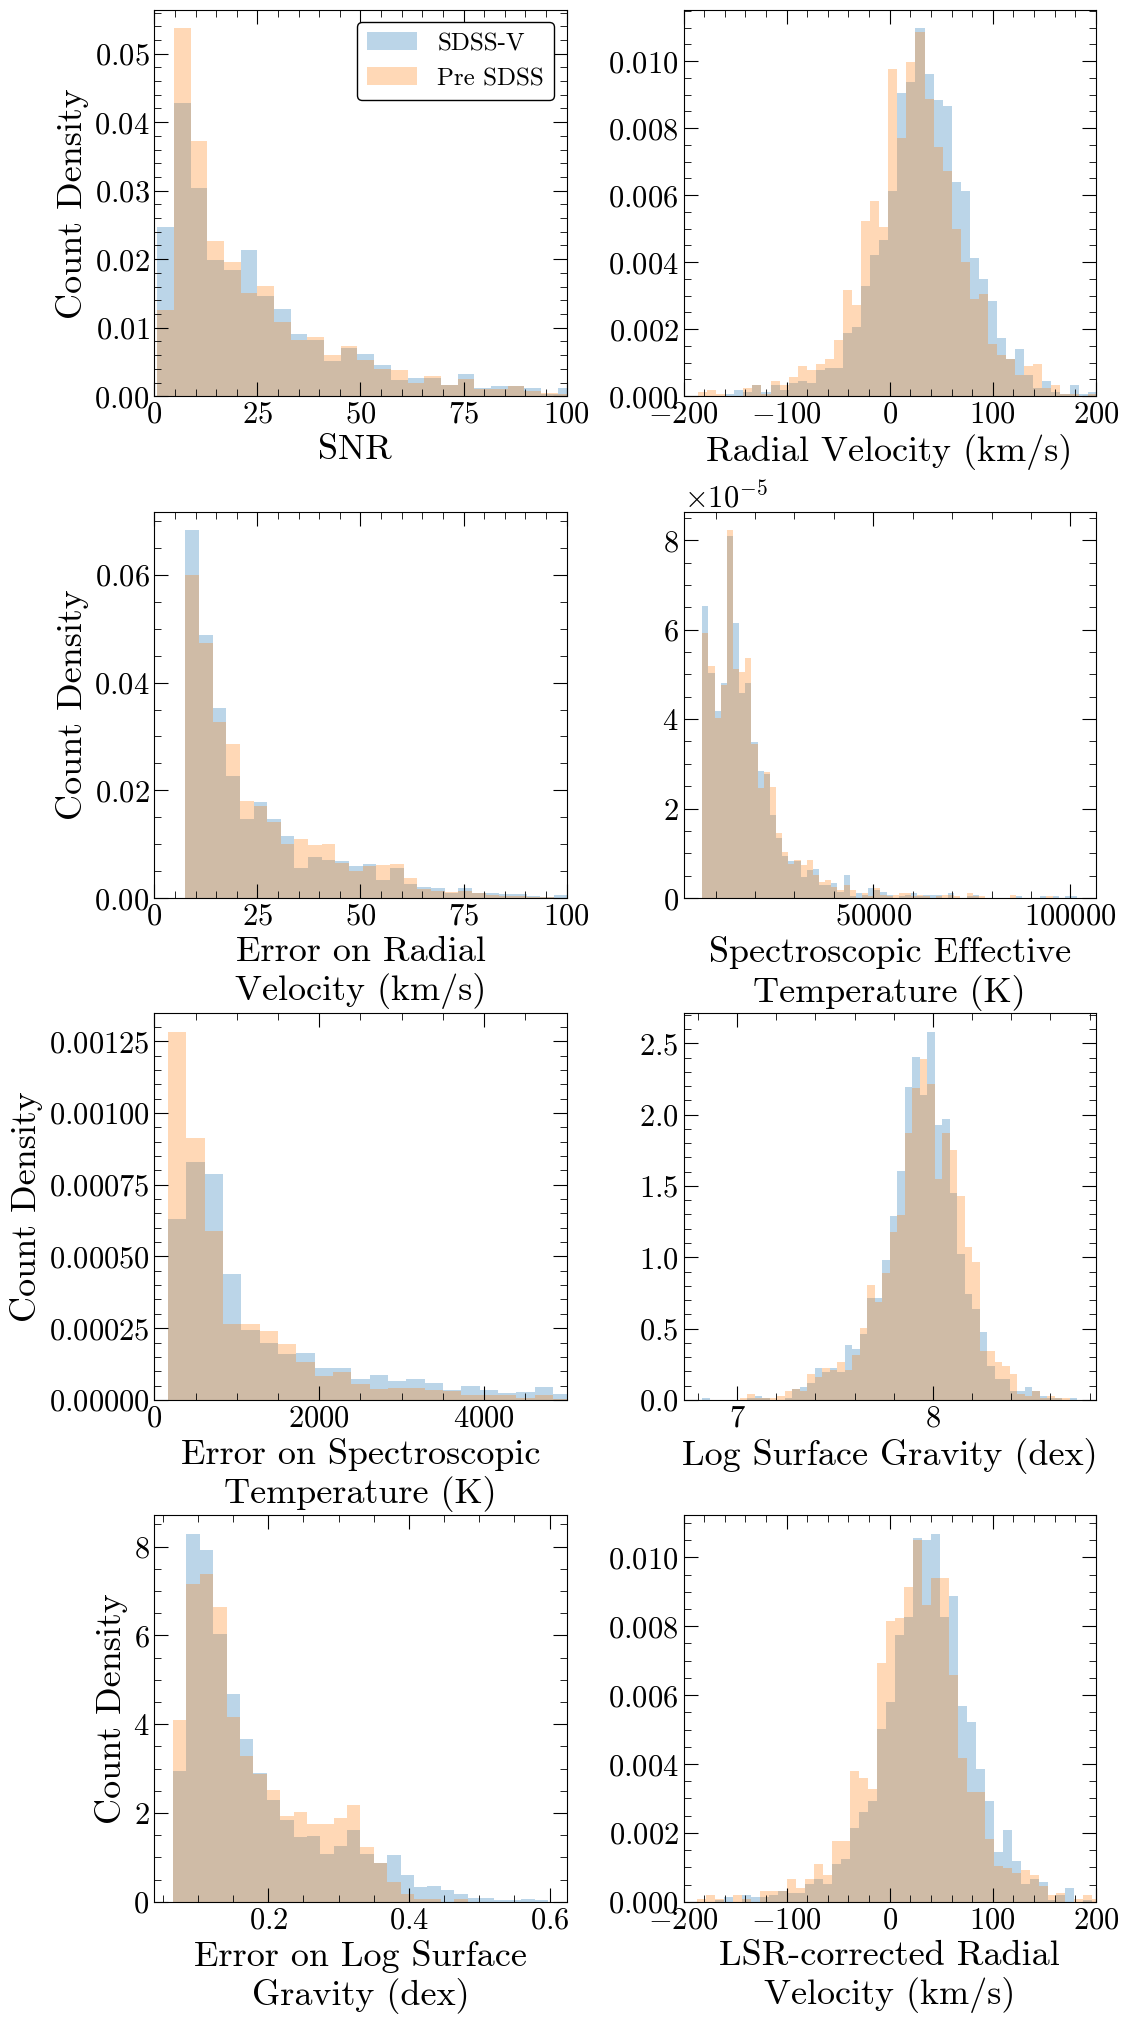

In [58]:
cols=['snr_coadd','rv_corv_coadd','e_rv_corv_coadd_full','teff_prf_coadd',
      'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr']
col_names=['SNR','Radial Velocity','Error on Radial\nVelocity','Spectroscopic Effective\nTemperature',
           'Error on Spectroscopic\nTemperature', 'Log Surface Gravity', 'Error on Log Surface\nGravity',
           'LSR-corrected Radial\nVelocity']
units=['','(km/s)','(km/s)','(K)','(K)','(dex)','(dex)','(km/s)']
lims=[[0,100],[-200,200],[0,100],0,[0,5000],0,0,[-200,200]]

fig= plt.figure(figsize=(11,24))
plt.style.use('stefan.mplstyle')

plotnum=1
for i in range(len(cols)):
    fig.add_subplot(5,2,int(plotnum))
    #if i==9:
    (n, bins, patches) =plt.hist(overlap[cols[i]+'_sdssv'],density=True,alpha=0.3,label='SDSS-V')
    plt.hist(overlap[cols[i]+'_esdss'],bins=bins,density=True,alpha=0.3,label='Pre SDSS')
    plt.xlabel(col_names[i]+' '+units[i])
    try:
        plt.xlim(lims[i][0],lims[i][1])
    except:
        pass
    plotnum=plotnum+1
    if i==0:
        plt.legend() 
    if i in (0,2,4,6,8):
        plt.ylabel('Count Density')
fig.tight_layout(pad=0.1)   

plt.savefig('SDSSV_vs_eSDSS_overlap_full.pdf')#,pad_inches=0.3)


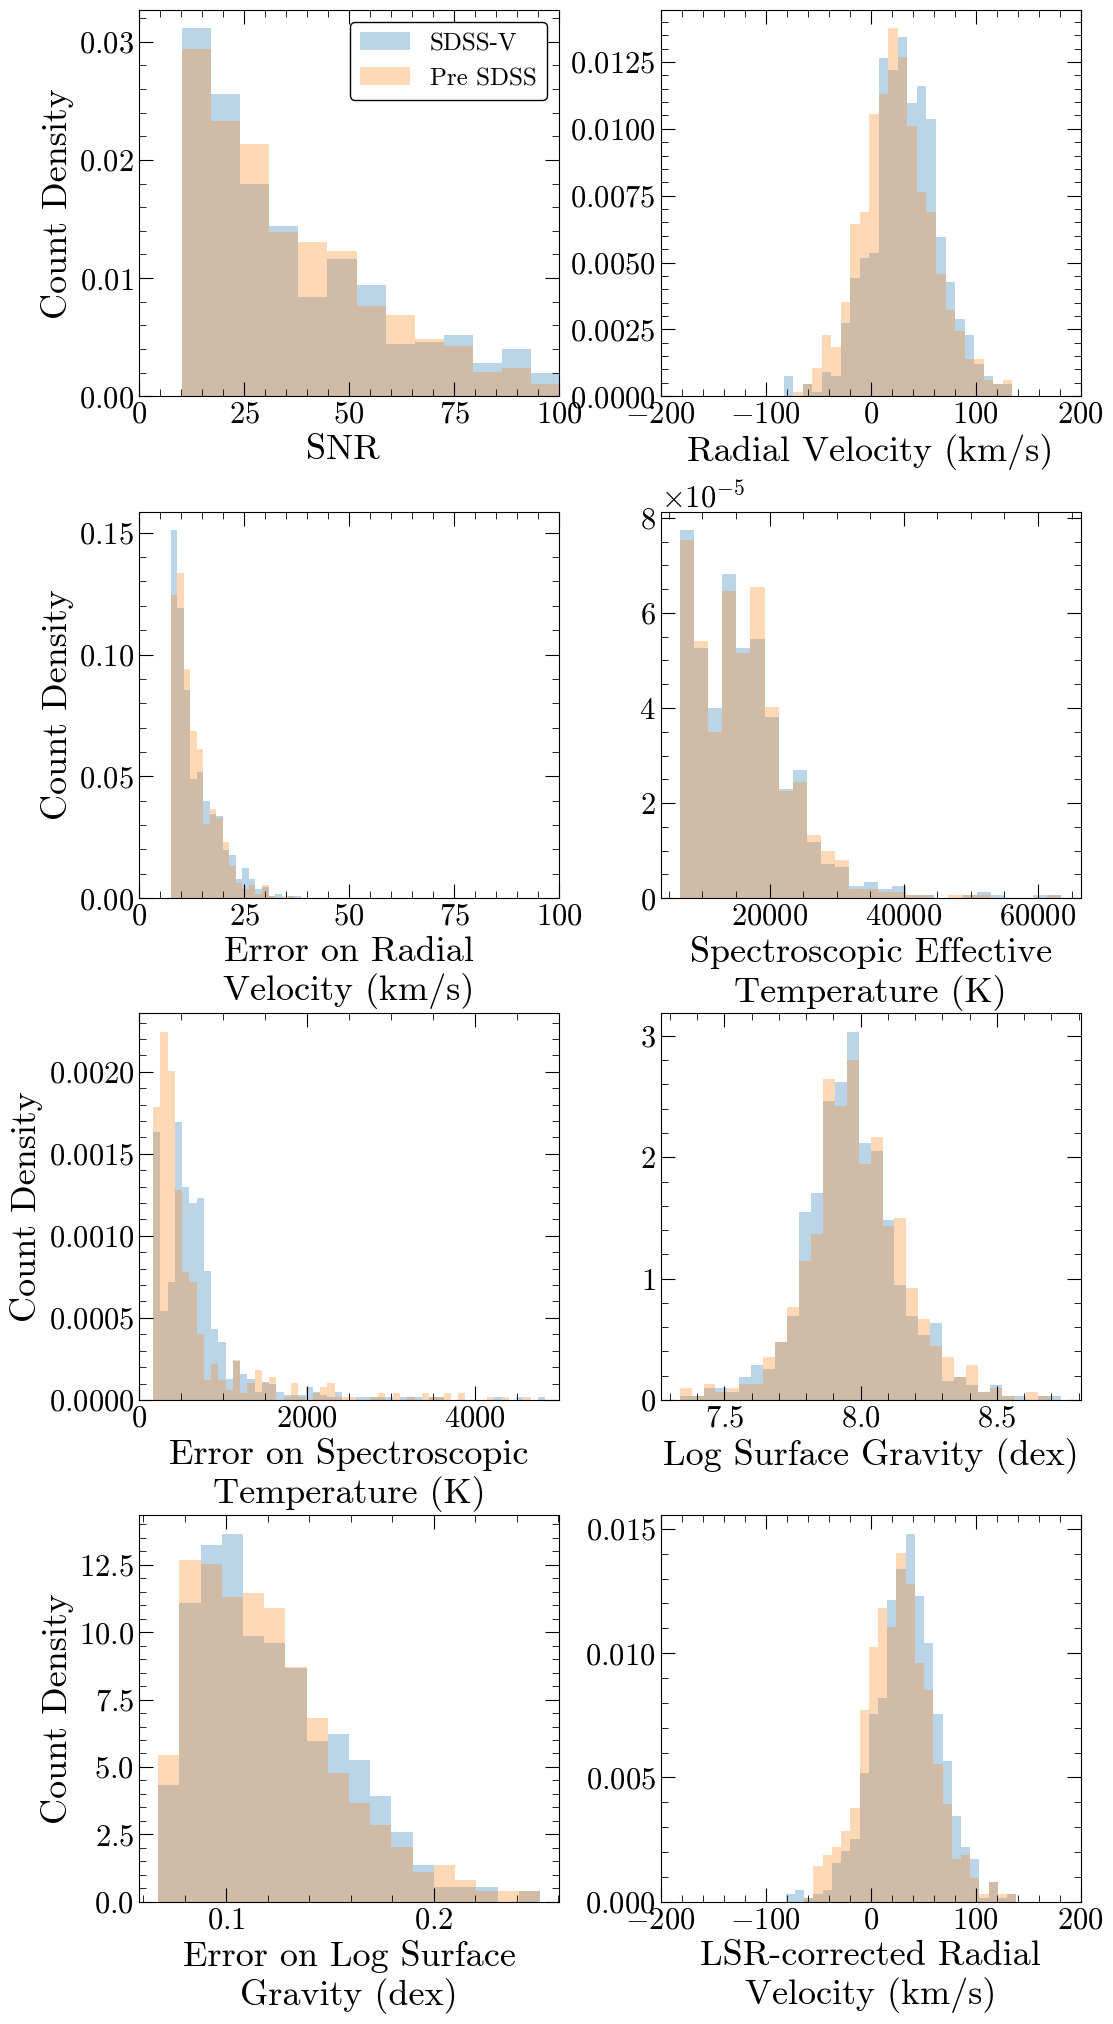

In [59]:
cols=['snr_coadd','rv_corv_coadd','e_rv_corv_coadd_full','teff_prf_coadd',
      'e_teff_prf_coadd_full','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr']
col_names=['SNR','Radial Velocity','Error on Radial\nVelocity','Spectroscopic Effective\nTemperature',
           'Error on Spectroscopic\nTemperature', 'Log Surface Gravity', 'Error on Log Surface\nGravity',
           'LSR-corrected Radial\nVelocity']
units=['','(km/s)','(km/s)','(K)','(K)','(dex)','(dex)','(km/s)']
lims=[[0,100],[-200,200],[0,100],0,[0,5000],0,0,[-200,200]]

fig= plt.figure(figsize=(11,24))
plt.style.use('stefan.mplstyle')

plotnum=1
for i in range(len(cols)):
    fig.add_subplot(5,2,int(plotnum))
    #if i==9:
    (n, bins, patches) =plt.hist(overlap_tempdep[cols[i]+'_sdssv'],density=True,alpha=0.3,label='SDSS-V')
    plt.hist(overlap_tempdep[cols[i]+'_esdss'],bins=bins,density=True,alpha=0.3,label='Pre SDSS')
    plt.xlabel(col_names[i]+' '+units[i])
    try:
        plt.xlim(lims[i][0],lims[i][1])
    except:
        pass
    plotnum=plotnum+1
    if i==0:
        plt.legend() 
    if i in (0,2,4,6,8):
        plt.ylabel('Count Density')
fig.tight_layout(pad=0.1)   

plt.savefig('SDSSV_vs_eSDSS_overlap_tempdep.pdf')#,pad_inches=0.3)



In [60]:
# get difference between coadd RV/logg in SDSS-V and eSDSS
# and get difference in coadd snrs
e_rv_diffs=overlap['e_rv_corv_coadd_full_sdssv']-overlap['e_rv_corv_coadd_full_esdss']
rv_diffs=overlap['rv_corv_coadd_sdssv']-overlap['rv_corv_coadd_esdss']
e_logg_diffs=overlap['e_logg_prf_coadd_full_sdssv']-overlap['e_logg_prf_coadd_full_esdss']
logg_diffs=overlap['logg_prf_coadd_sdssv']-overlap['logg_prf_coadd_esdss']
snr_diffs=overlap['snr_coadd_sdssv']-overlap['snr_coadd_esdss']

e_rv_diffs_tempdep=overlap_tempdep['e_rv_corv_coadd_full_sdssv']-overlap_tempdep['e_rv_corv_coadd_full_esdss']
rv_diffs_tempdep=overlap_tempdep['rv_corv_coadd_sdssv']-overlap_tempdep['rv_corv_coadd_esdss']
snr_diffs_tempdep=overlap_tempdep['snr_coadd_sdssv']-overlap_tempdep['snr_coadd_esdss']

print('full sample RV std= ',np.std(overlap['rv_corv_coadd_sdssv']),np.std(overlap['rv_corv_coadd_esdss']))
print('full sample mean RV difference= ',np.mean(rv_diffs))
print('full sample mean logg difference= ',np.mean(logg_diffs))

print('')
print('Temp dep sample RV std= ',np.std(overlap_tempdep['rv_corv_coadd_sdssv']),np.std(overlap_tempdep['rv_corv_coadd_esdss']))
print('Temp dep sample mean RV difference= ',np.mean(rv_diffs_tempdep))



full sample RV std=  65.99573876800405 74.6295704694487
full sample mean RV difference=  11.497524977694907
full sample mean logg difference=  -0.014658840909090922

Temp dep sample RV std=  33.10133718990609 34.5612087465562
Temp dep sample mean RV difference=  7.710700800806045


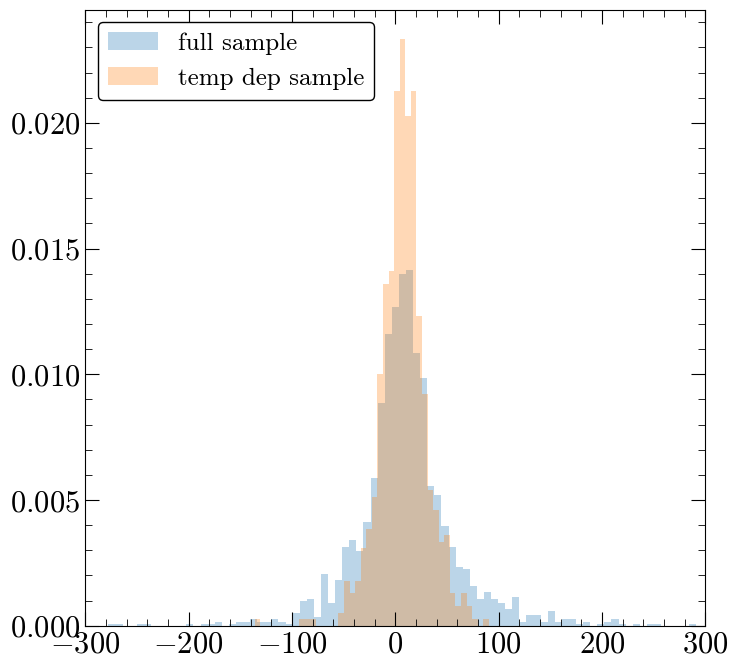

In [61]:
fig, ax1 =plt.subplots(1,1,figsize=(8,8))
plt.style.use('stefan.mplstyle')
out=ax1.hist(rv_diffs,density=True,alpha=0.3,label='full sample')
out=ax1.hist(rv_diffs_tempdep,density=True,alpha=0.3,label='temp dep sample')
ax1.set_xlim(-300,300)
ax1.legend()

Text(0.5, 0, 'SDSS-V RV (km/s)')

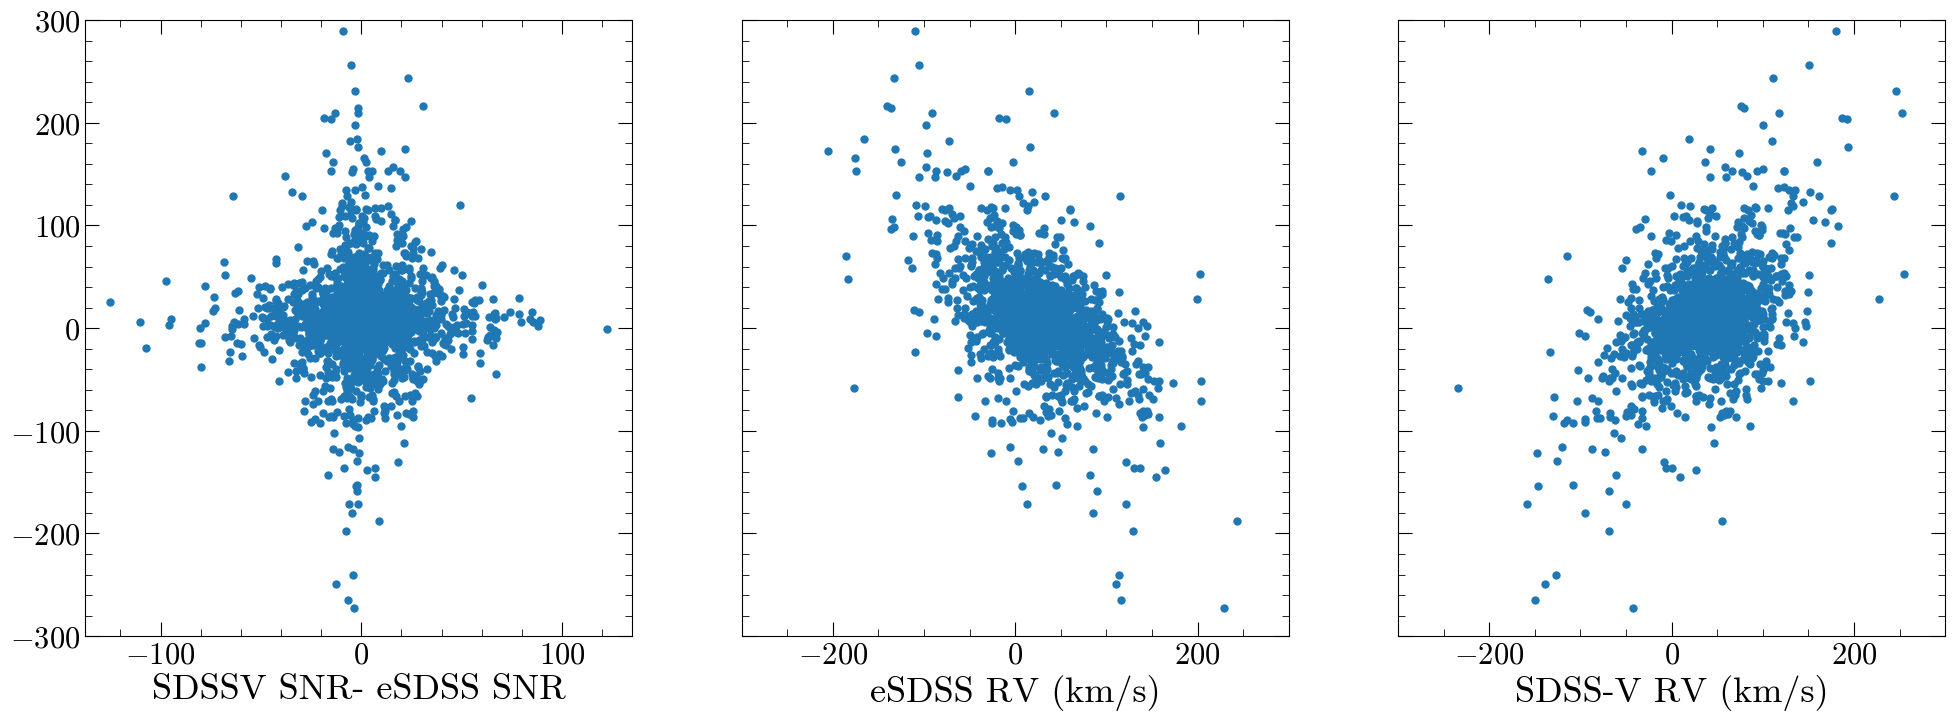

In [62]:
fig, (ax1,ax2,ax3) =plt.subplots(1,3,figsize=(24,8),sharey=True)
plt.style.use('stefan.mplstyle')
ax1.scatter(snr_diffs,rv_diffs)
ax1.set_ylim(-300,300)
ax1.set_xlabel('SDSSV SNR- eSDSS SNR')
ax2.scatter(overlap['rv_corv_coadd_esdss'],rv_diffs)
ax2.set_xlim(-300,300)
ax2.set_xlabel('eSDSS RV (km/s)')
ax3.scatter(overlap['rv_corv_coadd_sdssv'],rv_diffs)
ax3.set_xlim(-300,300)
ax3.set_xlabel('SDSS-V RV (km/s)')

# Photometric vs spectroscopic Teff

In [63]:
def comparison_stats(wd_table,cat1,cat2,meas_param,unit):
    
    error=wd_table[meas_param+'_'+cat1]-wd_table[meas_param+'_'+cat2]
    frac_err=error/wd_table[meas_param+'_'+cat1]
    
    #calculate the rmse between the datasets
    rmse = 0
    for i in range(len(wd_table)):
        rmse += (error[i])**2
    rmse = np.sqrt(rmse / len(wd_table))
    print(r''+meas_param+' RMSE: {:2.3f} '.format(rmse)+unit)
    
    #calculate the median absolute error between the datasets
    mae=np.median(np.abs(error))
    print(meas_param+' MAE: {:2.3f} '.format(mae)+unit)

    #calculate the bias between the datasets
    bias=np.median(error)
    print(meas_param+' BIAS: {:2.3f} '.format(bias)+unit)
    
    #calculate the median absolute fractional error
    med_frac=np.median(np.abs(frac_err))
    print(meas_param+' MED FRAC ERR: {:2.3f} '.format(med_frac))
        
    return(rmse,mae,bias,med_frac,error,frac_err)
def comparison_plots(wd_table,cat1,cat2,meas_param,unit,SDSSType='SDSSV',statx=100,staty=60,statdy=10,lim='default',
                   siegel=True,plthist=True,savefig=False):
    
    directcompplotname='DirectCompPlot_'+meas_param+'_'+cat1+'_'+cat2+'.png'
    directcompplottrendname='Trendlines_'+'DirectCompPlot_'+meas_param+'_'+cat1+'_'+cat2+'.png'
    AbsErrplotname='AbsErrplot_'+meas_param+'_'+cat1+'_'+cat2+'.png'
    Histplotname='Histplot_'+meas_param+'_'+cat1+'_'+cat2+'.png'
    
    #calculate stats
    rmse,mae,bias,med_frac,error,frac_err=comparison_stats(wd_table,cat1,cat2,meas_param,unit)
    
    #plot the agreement between the datasets, with stats
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    plt.style.use('stefan.mplstyle')
    ax1.errorbar(wd_table[meas_param+'_'+cat1], wd_table[meas_param+'_'+cat2], xerr = wd_table['e_'+meas_param+'_'+cat1],
                 yerr = wd_table['e_'+meas_param+'_'+cat2], fmt='o', color='blue', ecolor = 'teal')
    ax1.text(statx, staty, 'RMSE = {:.3f} '.format(rmse)+unit)
    ax1.text(statx, staty-1*statdy, 'MAE = {:.3f} '.format(mae)+unit)
    ax1.text(statx, staty-2*statdy, 'Bias = {:.3f} '.format(bias)+unit)
    ax1.set_xlabel(r''+meas_param+' ('+cat1+') $['+unit+']$')
    ax1.set_ylabel(r''+meas_param+'('+cat2+') $['+unit+']$')
    maxval=max(max(wd_table[meas_param+'_'+cat1]),max(wd_table[meas_param+'_'+cat2]))
    minval=min(min(wd_table[meas_param+'_'+cat1]),min(wd_table[meas_param+'_'+cat2]))
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
    if savefig==True:
        plt.savefig('plots/'+directcompplotname)
    plt.show()
    
    #plot the agreement between the datasets, with trendlines
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    plt.style.use('stefan.mplstyle')
    ax1.errorbar(wd_table[meas_param+'_'+cat1], wd_table[meas_param+'_'+cat2], xerr = wd_table['e_'+meas_param+'_'+cat1],
                 yerr = wd_table['e_'+meas_param+'_'+cat2], fmt='o', color='blue', ecolor = 'teal')
    ax1.set_xlabel(r''+meas_param+' ('+cat1+') $['+unit+']$')
    ax1.set_ylabel(r''+meas_param+'('+cat2+') $['+unit+']$')
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    #add a linear trendlines
    if siegel==True:
        coef = stats.siegelslopes(wd_table[meas_param+'_'+cat2], wd_table[meas_param+'_'+cat1])
        poly1d_fn = np.poly1d(coef) 
        ax1.plot([minval,maxval], poly1d_fn([minval,maxval]), label="Trendline\n"+str(np.round(coef[0],2))+"*x+"+str(np.round(coef[1],2)))
    else:
        coef= np.polyfit(wd_table[meas_param+'_'+cat1],wd_table[meas_param+'_'+cat2],1)
        poly1d_fn= np.poly1d(coef) 
        ax1.plot([minval,maxval], poly1d_fn([minval,maxval]), label="Trendline\n"+str(np.round(coef[0],2))+"*x+"+str(np.round(coef[1],2)))
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
    if savefig==True:
        plt.savefig('plots/'+directcompplottrendname)
    plt.show()



teff RMSE: 10261.673 K
teff MAE: 872.217 K
teff BIAS: -527.667 K
teff MED FRAC ERR: 0.059 


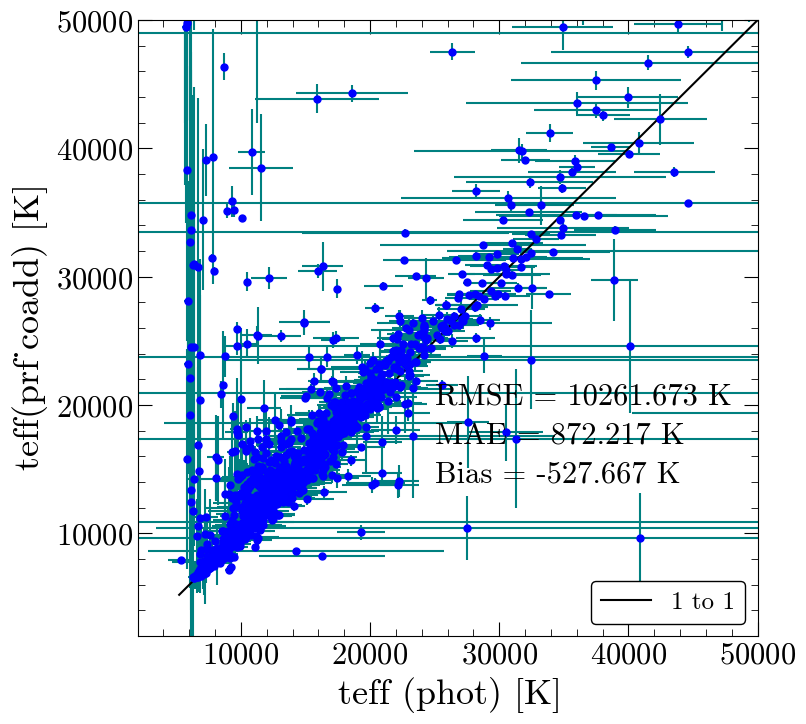

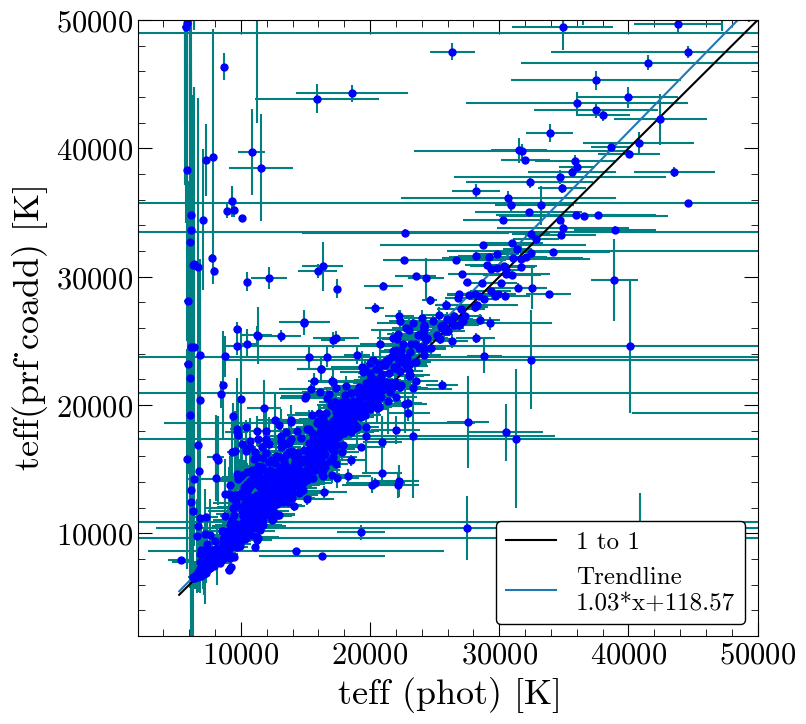

teff RMSE: 10938.070 K
teff MAE: 822.689 K
teff BIAS: -502.556 K
teff MED FRAC ERR: 0.048 


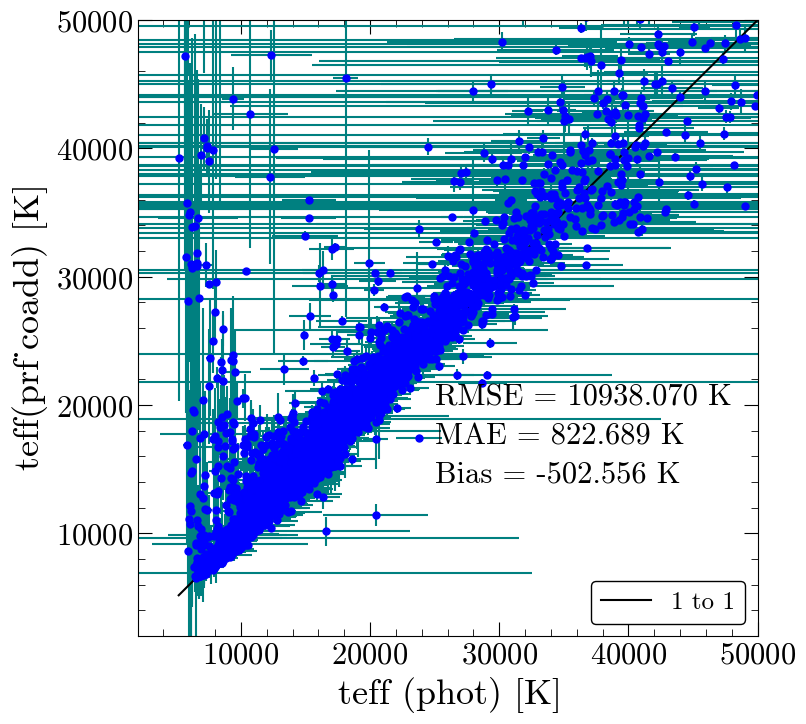

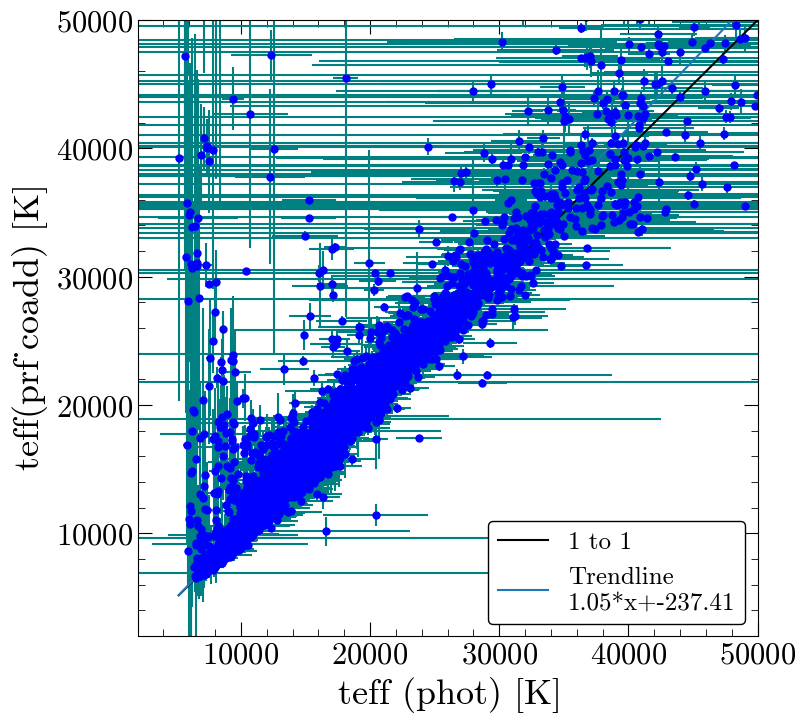

60
1383
0.04338394793926247

98
4859
0.02016875900391027


In [64]:
#compare the spectroscopic and photometric temperatures
SDSSV_tab_cut=SDSSV_tab.query('1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and snr_coadd>20').drop_duplicates(subset='gaia_dr3_source_id')
SDSSV_tab_cut=SDSSV_tab_cut.query('(phot_used==1 & phot_err_sdss<0.05) or (phot_used==2 & phot_err_gaia<10)')
#reset the indices
indices=np.arange(0,len(SDSSV_tab_cut))
SDSSV_tab_cut.set_index(indices,inplace=True)

comparison_plots(SDSSV_tab_cut,'phot','prf_coadd','teff','K',statx=25000,staty=20000,statdy=3000,lim=(2000,50000),
                   siegel=True,plthist=True,savefig=False)

#compare the spectroscopic and photometric temperatures
eSDSS_tab_cut=eSDSS_tab.query('1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and snr_coadd>20').drop_duplicates(subset='gaia_dr3_source_id')
eSDSS_tab_cut=eSDSS_tab_cut.query('(phot_used==1 & phot_err_sdss<0.05) or (phot_used==2 & phot_err_gaia<10)')
#reset the indices
indices=np.arange(0,len(eSDSS_tab_cut))
eSDSS_tab_cut.set_index(indices,inplace=True)

comparison_plots(eSDSS_tab_cut,'phot','prf_coadd','teff','K',statx=25000,staty=20000,statdy=3000,lim=(2000,50000),
                   siegel=True,plthist=True,savefig=False)

#number of anomalous 
print(len(SDSSV_tab_cut.query('5000<teff_phot<15000 and 20000<teff_prf_coadd')))
print(len(SDSSV_tab_cut))
print(len(SDSSV_tab_cut.query('5000<teff_phot<15000 and 20000<teff_prf_coadd'))/len(SDSSV_tab_cut))

print('')

print(len(eSDSS_tab_cut.query('5000<teff_phot<15000 and 20000<teff_prf_coadd')))
print(len(eSDSS_tab_cut))
print(len(eSDSS_tab_cut.query('5000<teff_phot<15000 and 20000<teff_prf_coadd'))/len(eSDSS_tab_cut))

In [65]:
#percent of anamolous fits
(60+98)/(1383+4859)

0.02531239987183595

# Random Stuff For Paper

In [66]:
print(np.mean(SDSSV_tab.query('5<snr<10')['e_rv_corv_ind_full']))
print(np.mean(eSDSS_tab.query('5<snr<10')['e_rv_corv_ind_full']))

39.60639356250743
43.50089733258899


In [67]:
print(np.mean(SDSSV_tab.query('5<snr<10')['e_logg_prf_ind_full']))
print(np.mean(eSDSS_tab.query('5<snr<10')['e_logg_prf_ind_full']))

0.25246094189228346
0.2534751974487883


In [68]:
print(np.mean(SDSSV_tab.query('5<snr<10')['e_teff_prf_ind_full']/SDSSV_tab.query('5<snr<10')['teff_prf_ind']))
print(np.mean(eSDSS_tab.query('5<snr<10')['e_teff_prf_ind_full']/eSDSS_tab.query('5<snr<10')['teff_prf_ind']))

0.13393893260580858
0.09433743656565954


In [69]:
#what is the typical LSR correction

SDSSV_lsr_corr=SDSSV_tab_tempdep.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_coadd']-SDSSV_tab_tempdep.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_lsr']
eSDSS_lsr_corr=eSDSS_tab_tempdep.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_coadd']-eSDSS_tab_tempdep.drop_duplicates(subset='gaia_dr3_source_id')['rv_corv_lsr']

print('min and max corr for SDSSV=',min(SDSSV_lsr_corr),', ',max(SDSSV_lsr_corr))
print('min and max corr for eSDSS=',min(eSDSS_lsr_corr),', ',max(eSDSS_lsr_corr))
print('')

print('overall mean corr for SDSSV=',np.mean(SDSSV_lsr_corr),'for eSDSS=',np.mean(eSDSS_lsr_corr))
print('overall mean abs corr for SDSSV=',np.mean(np.abs(SDSSV_lsr_corr)),'for eSDSS=',np.mean(np.abs(eSDSS_lsr_corr)))
print('')

SDSSV_mean_l=np.mean(SDSSV_tab_tempdep['l'])
SDSSV_mean_b=np.mean(SDSSV_tab_tempdep['b'])
eSDSS_mean_l=np.mean(eSDSS_tab_tempdep['l'])
eSDSS_mean_b=np.mean(eSDSS_tab_tempdep['b'])

print('SDSSV mean l,b=',SDSSV_mean_l,SDSSV_mean_b)
print('eSDSS mean l,b=',eSDSS_mean_l,eSDSS_mean_b)
print('')

SDSSV_peak_coord=SDSSV_tab_tempdep.query('@SDSSV_mean_l-10<l<@SDSSV_mean_l+10 & @SDSSV_mean_b-10<b<@SDSSV_mean_b+10')
eSDSS_peak_coord=eSDSS_tab_tempdep.query('@eSDSS_mean_l-10<l<@eSDSS_mean_l+10 & @eSDSS_mean_b-10<b<@eSDSS_mean_b+10')
SDSSV_lsr_corr=SDSSV_peak_coord['rv_corv_coadd']-SDSSV_peak_coord['rv_corv_lsr']
eSDSS_lsr_corr=eSDSS_peak_coord['rv_corv_coadd']-eSDSS_peak_coord['rv_corv_lsr']
print('at mean (l,b), mean corr for SDSSV=',np.mean(SDSSV_lsr_corr),'for eSDSS=',np.mean(eSDSS_lsr_corr))
print('at mean (l,b), mean abs corr for SDSSV=',np.mean(np.abs(SDSSV_lsr_corr)),'for eSDSS=',np.mean(np.abs(eSDSS_lsr_corr)))
print('')

#eSDSS has far more WDs at b=+-50 and none at b=0, SDSSV has more at b=0

SDSSV_peak_coord=SDSSV_tab_tempdep.query('@SDSSV_mean_l-10<l<@SDSSV_mean_l+10 & -10<b<10')
eSDSS_peak_coord=eSDSS_tab_tempdep.query('@eSDSS_mean_l-10<l<@eSDSS_mean_l+10 & 40<b<60')
SDSSV_lsr_corr=SDSSV_peak_coord['rv_corv_coadd']-SDSSV_peak_coord['rv_corv_lsr']
eSDSS_lsr_corr=eSDSS_peak_coord['rv_corv_coadd']-eSDSS_peak_coord['rv_corv_lsr']
print('at mean l, mean corr for SDSSV (b=0)=',np.mean(SDSSV_lsr_corr),'for eSDSS (b=50)=',np.mean(eSDSS_lsr_corr))
print('at mean l, mean abs corr for SDSSV(b=0)=',np.mean(np.abs(SDSSV_lsr_corr)),'for eSDSS (b=50)=',np.mean(np.abs(eSDSS_lsr_corr)))
print('')

min and max corr for SDSSV= -17.849499147873154 ,  17.140950932071455
min and max corr for eSDSS= -18.034419668178046 ,  16.739270534119523

overall mean corr for SDSSV= -3.3071873058561403 for eSDSS= -3.0919611101400895
overall mean abs corr for SDSSV= 10.547557508584143 for eSDSS= 8.105822452640135

SDSSV mean l,b= 140.53771636181114 12.90277942008741
eSDSS mean l,b= 151.00097339359385 33.055001986207564

at mean (l,b), mean corr for SDSSV= -0.018143689345577158 for eSDSS= -0.843576789445277
at mean (l,b), mean abs corr for SDSSV= 0.19120907087645955 for eSDSS= 1.03347732090686

at mean l, mean corr for SDSSV (b=0)= -0.10874079028966366 for eSDSS (b=50)= -3.035735591154451
at mean l, mean abs corr for SDSSV(b=0)= 0.1890282045776045 for eSDSS (b=50)= 3.038834222013798



In [70]:
#number unique WDs within 100 pc
sdssv_100pc=SDSSV_tab.query('r_med_geo<100').drop_duplicates(subset='gaia_dr3_source_id')[['gaia_dr3_source_id','r_med_geo']]
esdss_100pc=eSDSS_tab.query('r_med_geo<100').drop_duplicates(subset='gaia_dr3_source_id')[['gaia_dr3_source_id','r_med_geo']]
nearsample=pd.merge(left=sdssv_100pc,right=esdss_100pc,on='gaia_dr3_source_id',how='outer')
display(nearsample)

gaia_dr3_source_id  r_med_geo_x  r_med_geo_y
0          74698071455360    67.303879     67.30388
1      213146823035276160    91.554710          NaN
2      258761510321879424    53.863277          NaN
3      261664427174056320    38.468796          NaN
4      261671470922942976    78.019493          NaN
...                   ...          ...          ...
1028  5180178266367085312          NaN     79.03699
1029  5763373596110853248          NaN     85.85885
1030  6898489884295407488          NaN     68.77994
1031  6907108371830928768          NaN     87.35339
1032  6917473674103954560          NaN     74.56500

[1033 rows x 3 columns]